# Group 4's NZ Median Housing Price Predictor

The rising cost of housing and the increasing cost of living are significant challenges that many families in Aotearoa face. As housing prices continue to escalate across various regions, it has become crucial to understand these trends and predict future changes. In this project, we set out to analyze housing price data across Aotearoa and develop a model that predicts median housing costs by region. By leveraging historical data and applying predictive modeling techniques, our aim is to provide insights into future housing prices, offering a valuable tool for understanding and potentially mitigating the pressures of rising housing costs.

We split the workload amongst all 4 of us and each group member was working on different algorithms and different data in some cases.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
import xicorpy as xi
import shap
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

## `GradientBoostingRegressor` and the Nelson dataset

In [4]:
nelson = pd.read_csv('datasets/Nelson.csv',index_col=False)
nelson.index = nelson.date
nelson.index = pd.to_datetime(nelson.index)
nelson = nelson[['Nelson', 'lagged']]
nelson.head(5)

,Nelson,lagged
date,,
1992-01-31,115000.0,NaN
1992-02-29,108000.0,115000.0
1992-03-31,115000.0,108000.0
1992-04-30,116000.0,115000.0
1992-05-31,115000.0,116000.0


---

### Other datasets

In [5]:
headers = [
    "Unemployment rate (% s.a.)",
    "Labour force Employed (000s s.a.)",
    "Labour force Employed (y/y%)",
    "Labour force Unemployed (000s s.a.)",
    "Labour force Unemployed (y/y%)",
    "Labour force Total (000s s.a.)",
    "Labour force Total (y/y%)",
    "Not in labour force (000s s.a.)",
    "Not in labour force (y/y%)",
    "Working-age population (000s s.a.)",
    "Working-age population (y/y%)",
    "Labour force participation rate (% s.a.)",
    "Labour cost index (LCI) (Index)",
    "Labour cost index (LCI) (y/y%)",
    "Average hourly earnings (ordinary time and overtime) ($)",
    "Average hourly earnings (ordinary time and overtime) (q/q%)",
    "Average hourly earnings (ordinary time and overtime) (y/y%)",
    "Private sector wages ($)",
    "Private sector wages (q/q%)",
    "Private sector wages (y/y%)",
    "Public sector wages ($)",
    "Public sector wages (q/q%)",
    "Public sector wages (y/y%)"
]

In [6]:
labour = pd.read_excel('datasets/added/labour.xlsx', skiprows=4)
labour.index = labour[labour.columns[0]]
labour.drop(columns=[labour.columns[0]], inplace=True)
labour.index = pd.to_datetime(labour.index)
labour.index.name = 'date'
labour.columns=headers
labour.head(5)

,Unemployment rate (% s.a.),Labour force Employed (000s s.a.),Labour force Employed (y/y%),Labour force Unemployed (000s s.a.),Labour force Unemployed (y/y%),Labour force Total (000s s.a.),Labour force Total (y/y%),Not in labour force (000s s.a.),Not in labour force (y/y%),Working-age population (000s s.a.),...,Labour cost index (LCI) (y/y%),Average hourly earnings (ordinary time and overtime) ($),Average hourly earnings (ordinary time and overtime) (q/q%),Average hourly earnings (ordinary time and overtime) (y/y%),Private sector wages ($),Private sector wages (q/q%),Private sector wages (y/y%),Public sector wages ($),Public sector wages (q/q%),Public sector wages (y/y%)
date,,,,,,,,,,,,,,,,,,,,,
1994-03-31,9.3,1582,3.7,162,-5.2,1744,2.8,983,-1.2,2728,...,1.0,14.94,0.6,0.9,14.29,0.8,1.3,16.94,0.8,1.1
1994-06-30,8.5,1599,4.2,149,-13.8,1749,2.4,988,-0.4,2737,...,0.9,15.06,0.8,1.3,14.45,1.1,1.9,16.97,0.2,1.1
1994-09-30,8.0,1620,4.5,140,-14.2,1761,2.7,988,-0.8,2748,...,1.2,15.05,-0.1,1.7,14.47,0.1,2.7,16.87,-0.6,0.7
1994-12-31,7.6,1643,4.9,135,-17.1,1778,2.8,979,-1.0,2758,...,1.2,15.12,0.5,1.8,14.48,0.1,2.1,17.17,1.8,2.2
1995-03-31,6.8,1662,5.1,121,-25.1,1783,2.1,987,0.3,2770,...,1.3,15.23,0.7,1.9,14.59,0.8,2.1,17.38,1.2,2.6


In [8]:
nelson_labour = nelson.merge(labour.shift(1), on='date', how='inner').dropna()
nelson_labour.head(5)

,Nelson,lagged,Unemployment rate (% s.a.),Labour force Employed (000s s.a.),Labour force Employed (y/y%),Labour force Unemployed (000s s.a.),Labour force Unemployed (y/y%),Labour force Total (000s s.a.),Labour force Total (y/y%),Not in labour force (000s s.a.),...,Labour cost index (LCI) (y/y%),Average hourly earnings (ordinary time and overtime) ($),Average hourly earnings (ordinary time and overtime) (q/q%),Average hourly earnings (ordinary time and overtime) (y/y%),Private sector wages ($),Private sector wages (q/q%),Private sector wages (y/y%),Public sector wages ($),Public sector wages (q/q%),Public sector wages (y/y%)
date,,,,,,,,,,,,,,,,,,,,,
1994-06-30,130000.0,132000.0,9.3,1582.0,3.7,162.0,-5.2,1744.0,2.8,983.0,...,1.0,14.94,0.6,0.9,14.29,0.8,1.3,16.94,0.8,1.1
1994-09-30,133500.0,133000.0,8.5,1599.0,4.2,149.0,-13.8,1749.0,2.4,988.0,...,0.9,15.06,0.8,1.3,14.45,1.1,1.9,16.97,0.2,1.1
1994-12-31,137500.0,141000.0,8.0,1620.0,4.5,140.0,-14.2,1761.0,2.7,988.0,...,1.2,15.05,-0.1,1.7,14.47,0.1,2.7,16.87,-0.6,0.7
1995-03-31,133500.0,135000.0,7.6,1643.0,4.9,135.0,-17.1,1778.0,2.8,979.0,...,1.2,15.12,0.5,1.8,14.48,0.1,2.1,17.17,1.8,2.2
1995-06-30,135000.0,140000.0,6.8,1662.0,5.1,121.0,-25.1,1783.0,2.1,987.0,...,1.3,15.23,0.7,1.9,14.59,0.8,2.1,17.38,1.2,2.6


---

### Initial EDA

In [7]:
xi.compute_xi_correlation(nelson, nelson.Nelson)

,Nelson
Nelson,1.000000
lagged,0.832985


In [9]:
xi.compute_xi_correlation(nelson_labour, nelson_labour.Nelson)

,Nelson
Nelson,1.000000
lagged,0.834059
Unemployment rate (% s.a.),0.146766
Labour force Employed (000s s.a.),0.844272
Labour force Employed (y/y%),0.014824
Labour force Unemployed (000s s.a.),0.067163
Labour force Unemployed (y/y%),0.051426
Labour force Total (000s s.a.),0.863507
Labour force Total (y/y%),0.064223
Not in labour force (000s s.a.),0.776990


---

### Helper Functions

In [13]:
def plot_pred_vs_actual(df, pred):
    plt.plot(df.sort_values(by='date').index, df.sort_values(by='date').Nelson)
    plt.plot(df.sort_values(by='date').index, pred)
    
def print_metrics(df, pred):
    mse = mean_squared_error(pred, df.sort_values(by='date').Nelson)
    rmse = root_mean_squared_error(pred, df.sort_values(by='date').Nelson)
    mae = mean_absolute_error(pred, df.sort_values(by='date').Nelson)
    mdae = median_absolute_error(pred, df.sort_values(by='date').Nelson)
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'MDAE: {mdae}')
    
        
def predict_year_end_2024(gbt: GradientBoostingRegressor, last_val, df_nelson):
    df = df_nelson.dropna().copy()
    last_val.rename(columns={'Nelson':'lagged'}, inplace=True)
    pred = None
    for i in range(4):
        pred = gbt.predict(last_val)
        date = df.iloc[-1].name + pd.tseries.offsets.MonthEnd()
        temp = pd.DataFrame([[pred[0], last_val.iloc[0,0]]], index=[date], columns=['Nelson', 'lagged'])
        df = pd.concat([df, temp])
        gbt.fit(df[['lagged']], df[['Nelson']])
        last_val = df[-1:][['Nelson']].copy()
        last_val.rename(columns={'Nelson':'lagged'}, inplace=True)
        
    return pred

---

### Training

In [10]:
train, test = train_test_split(nelson.dropna(), test_size=0.2, shuffle=True)

In [11]:
params = {
    "n_estimators": 200,
    "max_depth": 1,
    "min_samples_split": 5,
    "learning_rate": 0.2,
    "loss": "squared_error",
    "random_state": 42
}


gbf = GradientBoostingRegressor(**params)

In [12]:
gbf.fit(train[['lagged']], train[['Nelson']])

C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(learning_rate=0.2, max_depth=1, min_samples_split=5,
                          n_estimators=200, random_state=42)

In [14]:
test_pred = gbf.predict(test[['lagged']])

In [15]:
print_metrics(test, test_pred)

MSE: 57338350136.807304
RMSE: 239454.27567034026
MAE: 179770.59135828086
MDAE: 133036.5315809133


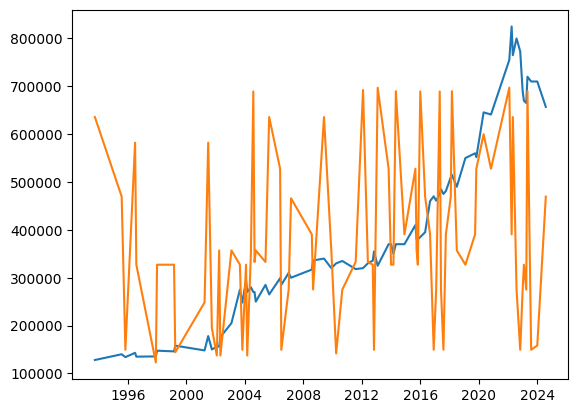

In [16]:
plot_pred_vs_actual(test, test_pred)

### `RandomizedSearchCV`

In [17]:
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(1, 10),
    'learning_rate': uniform(0.01, 0.4),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.5, 0.5)
}

gbr = GradientBoostingRegressor()

In [18]:
rs = RandomizedSearchCV(estimator=gbr, 
                                   param_distributions=param_dist, 
                                   n_iter=200,
                                   cv=5,
                                   random_state=42,
                                   n_jobs=-1)
search = rs.fit(train[['lagged']], train['Nelson'].values)

In [19]:
search.best_params_

{'learning_rate': 0.19019970078781723,
 'max_depth': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 15,
 'n_estimators': 58,
 'subsample': 0.5079831261101071}

In [20]:
test_pred = search.best_estimator_.predict(test[['lagged']])

In [21]:
print_metrics(test, test_pred)

MSE: 57033258942.597084
RMSE: 238816.37075920295
MAE: 178501.7715197787
MDAE: 137055.29377027464


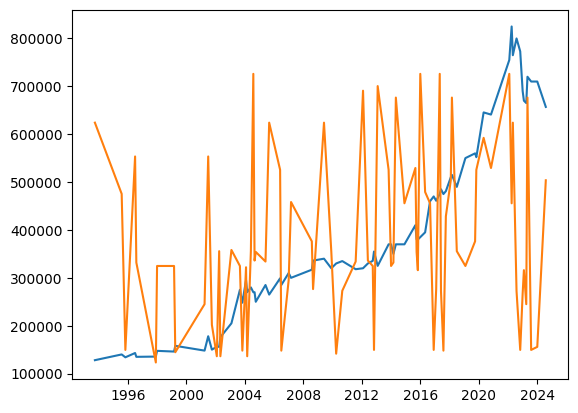

In [22]:
plot_pred_vs_actual(test, test_pred)

---

In [37]:
param_dist = {
    'n_estimators': randint(50, 5000),
    'max_depth': randint(1, 10),
    'learning_rate': uniform(0.01, 0.4),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.5, 0.5)
}

gbt = GradientBoostingRegressor()

In [38]:
rs = RandomizedSearchCV(estimator=gbr, 
                                   param_distributions=param_dist, 
                                   n_iter=200,
                                   cv=5,
                                   random_state=42,
                                   n_jobs=-1)
search = rs.fit(train[['lagged']], train['Nelson'].values)

In [39]:
test_pred = search.best_estimator_.predict(test[['lagged']])
print_metrics(test, test_pred)

MSE: 65489336430.196075
RMSE: 255908.84398589292
MAE: 192182.35171866618
MDAE: 186039.55790983088


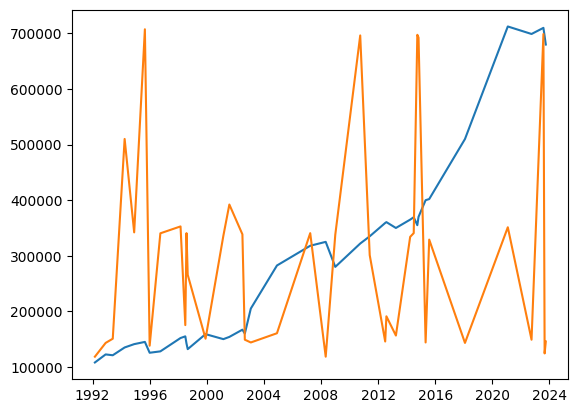

In [40]:
plot_pred_vs_actual(test, test_pred)

---

### Predicting last value

In [41]:

train, test = train_test_split(nelson.dropna()[:-1], test_size=0.1, random_state=42)

In [42]:
param_dist = {
    'n_estimators': 5000,
    'learning_rate': 0.01,
    'max_depth': 1,
    'loss':'squared_error',
    'random_state':42,
}

In [43]:
gbt = GradientBoostingRegressor(**param_dist)

In [44]:
gbt.fit(train[['lagged']], train[['Nelson']])

C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(learning_rate=0.01, max_depth=1, n_estimators=5000,
                          random_state=42)

In [45]:
test_pred = gbt.predict(test[['lagged']].sort_values(by='date'))

In [46]:
print_metrics(test, test_pred)

MSE: 323384648.29959553
RMSE: 17982.898773545814
MAE: 13784.365501384325
MDAE: 10019.443262467918


In [47]:
pred_last = gbt.predict(nelson[-1:][['lagged']])
print(f'Actual value: {nelson[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 693000.0, Predicted value: 698717.1561961945


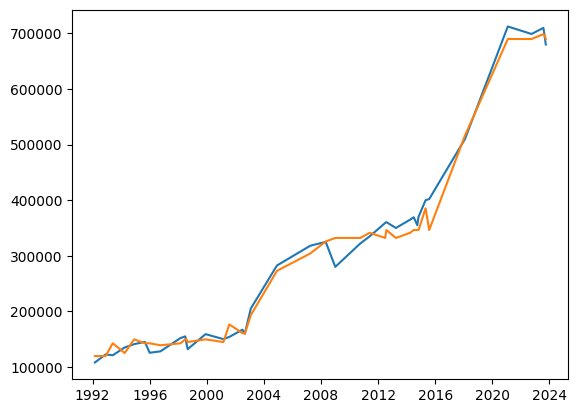

In [48]:
plot_pred_vs_actual(test, test_pred)

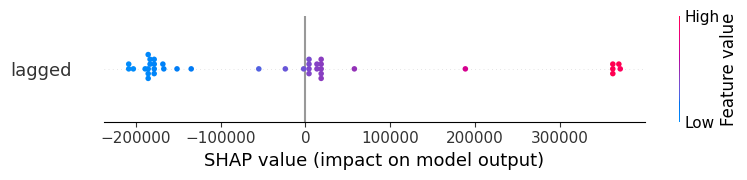

In [49]:
explainer = shap.Explainer(gbt, train[['lagged']])
shap_values = explainer.shap_values(test[['lagged']])
shap.summary_plot(shap_values, test[['lagged']])

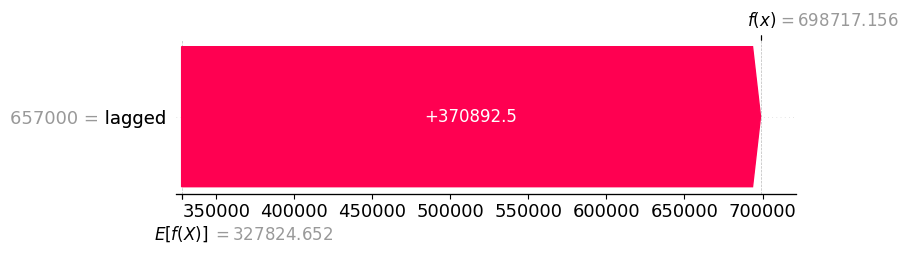

In [50]:
shap_values = explainer(nelson[-1:][['lagged']])
shap.waterfall_plot(shap_values[0])

---

## Different loss function

In [232]:
train, test = train_test_split(nelson.dropna()[:-1], test_size=0.1, random_state=42)

### Mean Absolute

In [180]:
param_dist = {
    'n_estimators': np.arange(1, 5000),
    'learning_rate': np.arange(0.01, 0.5),
    'max_depth': np.arange(1, 4),
    'loss':['absolute_error'],
}

random_search = RandomizedSearchCV(
    estimator=gbt,            
    param_distributions=param_dist,
    n_iter=100,              
    scoring='neg_root_mean_squared_error', 
    cv=5,                      
    random_state=42,            
    n_jobs=-1,
    verbose=2                   
)

random_search.fit(train.drop(columns=['Nelson']), train[['Nelson']])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01]),
                                        'loss': ['absolute_error'],
                                        'max_depth': array([1, 2, 3]),
                                        'n_estimators': array([   1,    2,    3, ..., 4997, 4998, 4999])},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [181]:
random_search.best_params_

{'n_estimators': 1022,
 'max_depth': 1,
 'loss': 'absolute_error',
 'learning_rate': 0.01}

In [182]:
test_pred = random_search.best_estimator_.predict(test.drop(columns=['Nelson']).sort_values(by='date'))
print_metrics(test, test_pred)

MSE: 415704993.96977794
RMSE: 20388.84484147589
MAE: 15470.16501084457
MDAE: 10739.130737690808


In [183]:
pred_last = random_search.best_estimator_.predict(nelson.dropna()[-1:].drop(columns=['Nelson']))
print(f'Actual value: {nelson.dropna()[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 693000.0, Predicted value: 670616.6962745901


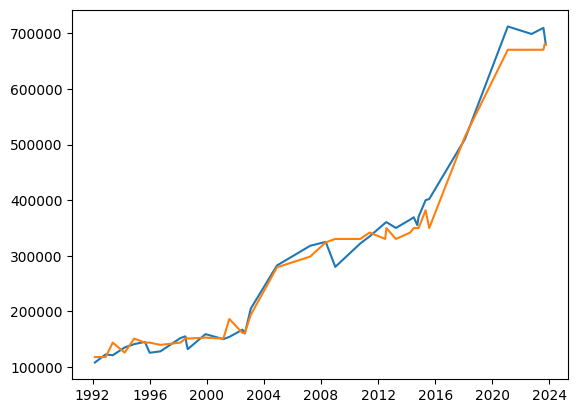

In [184]:
plot_pred_vs_actual(test, test_pred)

---

### Quantile loss

In [233]:
param_dist = {
    'n_estimators': [5000],
    'learning_rate': [0.1],
    'max_depth': [1],
    'loss':['quantile'],
    'alpha':np.arange(0.01, 1)
}

random_search = RandomizedSearchCV(
    estimator=gbt,            
    param_distributions=param_dist,
    n_iter=100,              
    scoring='neg_root_mean_squared_error', 
    cv=5,                      
    random_state=42,            
    n_jobs=-1                   
)

random_search.fit(train.drop(columns=['Nelson']), train[['Nelson']])

C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'alpha': array([0.01]),
                                        'learning_rate': [0.1],
                                        'loss': ['quantile'], 'max_depth': [1],
                                        'n_estimators': [5000]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [234]:
random_search.best_params_

{'n_estimators': 5000,
 'max_depth': 1,
 'loss': 'quantile',
 'learning_rate': 0.1,
 'alpha': 0.01}

In [235]:
test_pred = random_search.best_estimator_.predict(test.drop(columns=['Nelson']).sort_values(by='date'))
print_metrics(test, test_pred)

MSE: 66628668033.54281
RMSE: 258125.29522219012
MAE: 180927.42218949102
MDAE: 159863.80780559275


In [236]:
pred_last = random_search.best_estimator_.predict(nelson.dropna()[-1:].drop(columns=['Nelson']))
print(f'Actual value: {nelson.dropna()[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 693000.0, Predicted value: 122636.19219440737


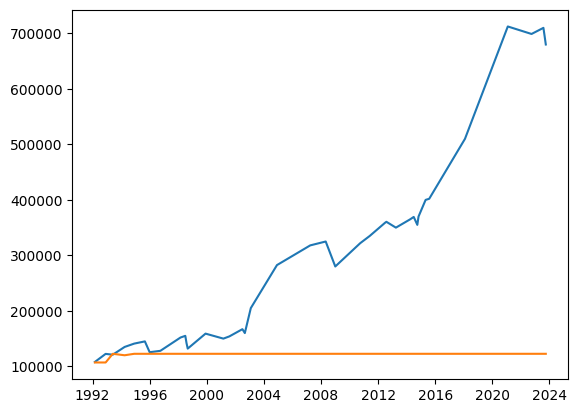

In [237]:
plot_pred_vs_actual(test, test_pred)

---

### Huber loss

In [238]:
params = {
    "n_estimators": 5000,
    "max_depth": 3,
    "learning_rate": 0.01,
    "random_state": 42,
    "loss": "huber",
    "alpha":0.6
}
gbt_huber = GradientBoostingRegressor(**params)

In [239]:
gbt_huber.fit(train.drop(columns=['Nelson']), train[['Nelson']])

C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(alpha=0.6, learning_rate=0.01, loss='huber',
                          n_estimators=5000, random_state=42)

In [240]:
test_pred = gbt_huber.predict(test.drop(columns=['Nelson']))
print_metrics(test, test_pred)

MSE: 64303682435.47113
RMSE: 253581.70761210503
MAE: 190671.97878489093
MDAE: 183168.6093479868


In [241]:
pred_last = random_search.best_estimator_.predict(nelson.dropna()[-1:].drop(columns=['Nelson']))
print(f'Actual value: {nelson.dropna()[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 693000.0, Predicted value: 122636.19219440737


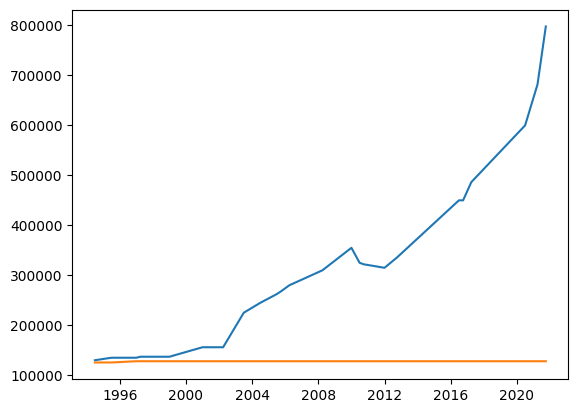

In [231]:
plot_pred_vs_actual(test, test_pred)

---

### Nelson_labour dataset

#### Without shuffling

In [187]:
df = xi.compute_xi_correlation(nelson_labour, nelson_labour.Nelson)
mask = np.where(df.Nelson.values > 0.8)
df.iloc[mask].index

Index(['Nelson', 'lagged', 'Labour force Employed (000s s.a.)',
       'Labour force Total (000s s.a.)', 'Working-age population (000s s.a.)',
       'Labour cost index (LCI) (Index)',
       'Average hourly earnings (ordinary time and overtime) ($)',
       'Private sector wages ($)', 'Public sector wages ($)'],
      dtype='object')

In [188]:
df_filtered = nelson_labour[df.iloc[mask].index]

In [189]:
train, test = train_test_split(df_filtered, test_size=0.2, shuffle=False)

In [190]:
params = {
    "n_estimators": 5000,
    "max_depth": 1,
    "learning_rate": 0.2,
    "random_state": 42
}
gbt = GradientBoostingRegressor(**params)

In [191]:
gbt.fit(train.drop(columns=['Nelson', 'lagged']), train.Nelson)

GradientBoostingRegressor(learning_rate=0.2, max_depth=1, n_estimators=5000,
                          random_state=42)

In [192]:
test_pred = gbt.predict(test.drop(columns=['Nelson', 'lagged']).sort_values(by='date'))
print_metrics(test, test_pred)

MSE: 30702472175.850708
RMSE: 175221.20926374954
MAE: 152865.9059713804
MDAE: 159167.70007636806


In [193]:
pred_last = gbt.predict(df_filtered[-1:].drop(columns=['Nelson', 'lagged']))
print(f'Actual value: {df_filtered[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 648000.0, Predicted value: 505832.29992363194


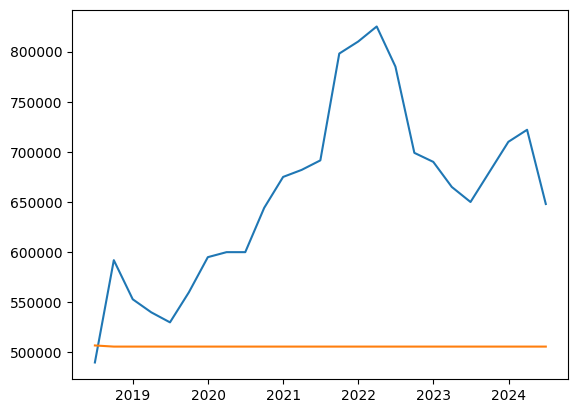

In [194]:
plot_pred_vs_actual(test, test_pred)

---

#### With shuffling

In [195]:
train, test = train_test_split(df_filtered[:-1], test_size=0.2, random_state=42)

In [196]:
params = {
    "n_estimators": 5000,
    "max_depth": 3,
    "learning_rate": 0.01,
    "random_state": 42
}

gbt = GradientBoostingRegressor(**params)

In [197]:
gbt.fit(train.drop(columns=['Nelson', 'lagged']), train[['Nelson']])

C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(learning_rate=0.01, n_estimators=5000,
                          random_state=42)

In [198]:
test_pred = gbt.predict(test.drop(columns=['Nelson', 'lagged']).sort_values(by='date'))
print_metrics(test, test_pred)

MSE: 787444456.4443766
RMSE: 28061.440740709957
MAE: 17646.825492809003
MDAE: 10285.844425658506


In [199]:
pred_last = gbt.predict(df_filtered[-1:].drop(columns=['Nelson', 'lagged']))
print(f'Actual value: {df_filtered[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 648000.0, Predicted value: 720157.6188833549


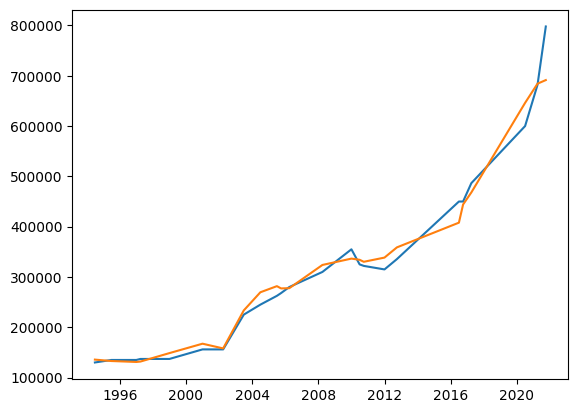

In [200]:
plot_pred_vs_actual(test, test_pred)

---

In [201]:

gbt = GradientBoostingRegressor()

param_dist = {
    'n_estimators': [1000, 5000],
    'learning_rate': [0.1],
    'max_depth': [1],
    'loss':['squared_error'],
}

random_search = RandomizedSearchCV(
    estimator=gbt,            
    param_distributions=param_dist,
    n_iter=100,              
    scoring='neg_root_mean_squared_error', 
    cv=5,                      
    random_state=42,            
    n_jobs=-1                   
)

random_search.fit(train.drop(columns=['Nelson']), train[['Nelson']])

C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.1],
                                        'loss': ['squared_error'],
                                        'max_depth': [1],
                                        'n_estimators': [1000, 5000]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [202]:
random_search.best_params_

{'n_estimators': 1000,
 'max_depth': 1,
 'loss': 'squared_error',
 'learning_rate': 0.1}

In [203]:
test_pred = random_search.best_estimator_.predict(test.drop(columns=['Nelson']).sort_values(by='date'))
print_metrics(test, test_pred)

MSE: 903188102.6452761
RMSE: 30053.088071698658
MAE: 18964.2076993657
MDAE: 11325.593148961372


In [204]:
pred_last = random_search.best_estimator_.predict(df_filtered[-1:].drop(columns='Nelson'))
print(f'Actual value: {df_filtered[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 648000.0, Predicted value: 695312.1235678649


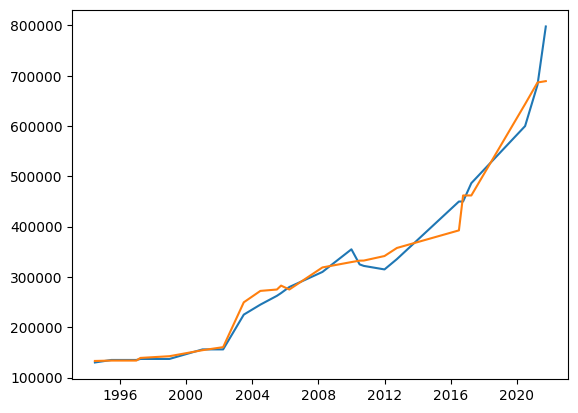

In [205]:
plot_pred_vs_actual(test, test_pred)

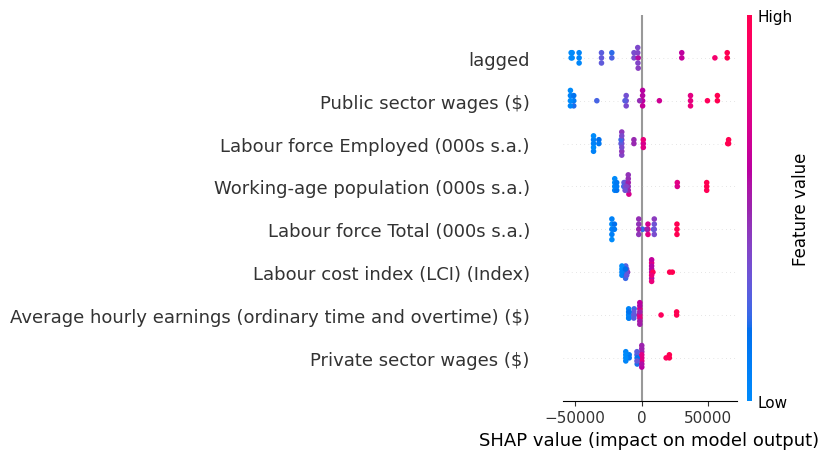

In [206]:
explainer = shap.Explainer(random_search.best_estimator_, train.drop(columns=['Nelson']))
shap_values = explainer.shap_values(test.drop(columns=['Nelson']))
shap.summary_plot(shap_values, test.drop(columns=['Nelson']))

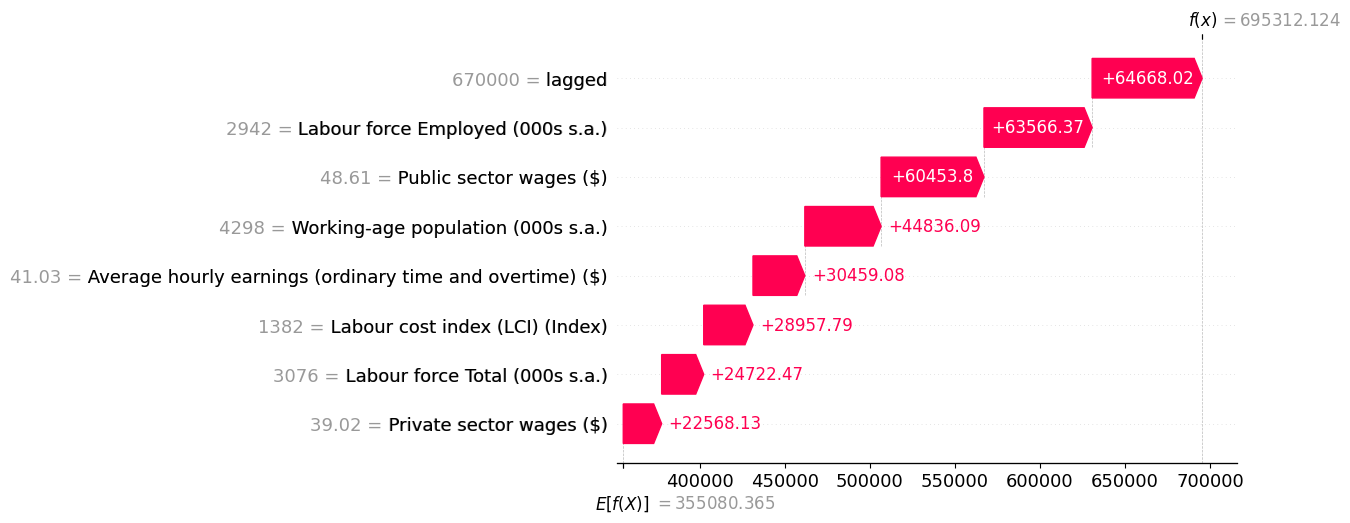

In [207]:
shap_values = explainer(df_filtered[-1:].drop(columns='Nelson'))
shap.waterfall_plot(shap_values[0])

---

### Playing around with different features

SHAP analysis shows the influence of different features, as the model seems to be overshooting the final prediction, it might be interesting to see the result of removing some more influencial features.

Drop `Public sector wages ($)`

In [208]:
shap_headers = [
    'lagged', 'Labour force Employed (000s s.a.)',
       'Labour force Total (000s s.a.)', 'Working-age population (000s s.a.)',
       'Labour cost index (LCI) (Index)',
       'Average hourly earnings (ordinary time and overtime) ($)',
       'Private sector wages ($)'
]

In [209]:
gbt = GradientBoostingRegressor()

param_dist = {
    'n_estimators': np.arange(500, 5000),
    'learning_rate': np.arange(0.01, 0.4),
    'max_depth': range(1, 4),
    'loss':['squared_error'],
    'random_state':[42]
}

random_search = RandomizedSearchCV(
    estimator=gbt,            
    param_distributions=param_dist,
    n_iter=100,              
    scoring='neg_root_mean_squared_error', 
    cv=5,                      
    random_state=42,            
    n_jobs=-1,
    verbose=2                   
)

random_search.fit(train[shap_headers], train[['Nelson']])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01]),
                                        'loss': ['squared_error'],
                                        'max_depth': range(1, 4),
                                        'n_estimators': array([ 500,  501,  502, ..., 4997, 4998, 4999]),
                                        'random_state': [42]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [210]:
test_pred = random_search.best_estimator_.predict(test[shap_headers].sort_values(by='date'))
print_metrics(test, test_pred)

MSE: 774481062.8684462
RMSE: 27829.49986737897
MAE: 16793.3182994548
MDAE: 8368.309813601765


In [211]:
pred_last = random_search.best_estimator_.predict(df_filtered[-1:][shap_headers])
print(f'Actual value: {df_filtered[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 648000.0, Predicted value: 703771.0895054507


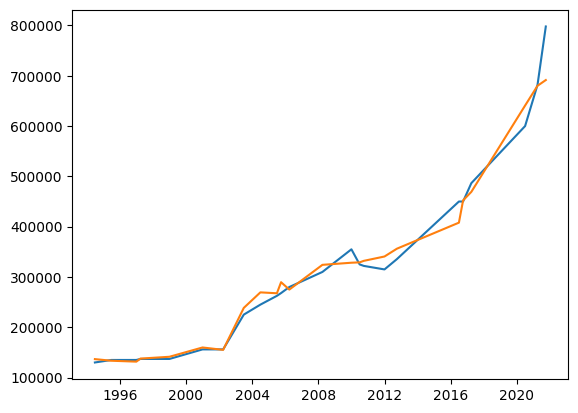

In [212]:
plot_pred_vs_actual(test, test_pred)

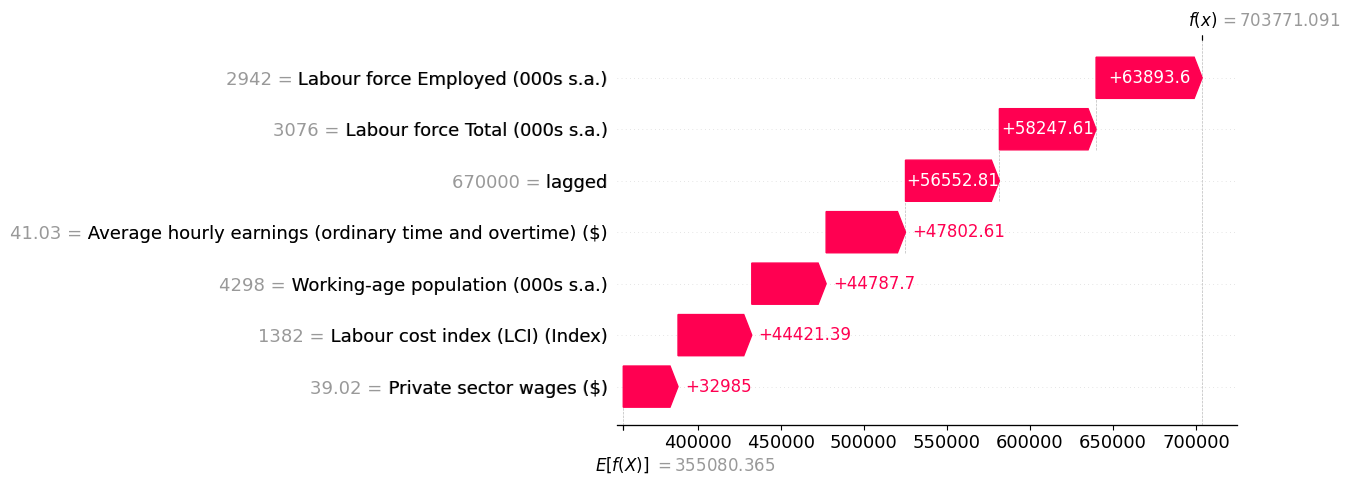

In [213]:
explainer = shap.Explainer(random_search.best_estimator_, train[shap_headers])
shap_values = explainer(df_filtered[-1:][shap_headers])
shap.waterfall_plot(shap_values[0])

---

Drop `lagged`

In [214]:
shap_headers = [
    'Public sector wages ($)', 'Labour force Employed (000s s.a.)',
       'Labour force Total (000s s.a.)', 'Working-age population (000s s.a.)',
       'Labour cost index (LCI) (Index)',
       'Average hourly earnings (ordinary time and overtime) ($)',
       'Private sector wages ($)'
]

In [215]:
gbt = GradientBoostingRegressor()

param_dist = {
    'n_estimators': np.arange(500, 5000),
    'learning_rate': np.arange(0.01, 0.4),
    'max_depth': range(1, 4),
    'loss':['squared_error'],
    'random_state':[42]
}

random_search = RandomizedSearchCV(
    estimator=gbt,            
    param_distributions=param_dist,
    n_iter=100,              
    scoring='neg_root_mean_squared_error', 
    cv=5,                      
    random_state=42,            
    n_jobs=-1,
    verbose=2                   
)

random_search.fit(train[shap_headers], train[['Nelson']])
random_search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


{'random_state': 42,
 'n_estimators': 667,
 'max_depth': 3,
 'loss': 'squared_error',
 'learning_rate': 0.01}

In [216]:
test_pred = random_search.best_estimator_.predict(test[shap_headers].sort_values(by='date'))
print_metrics(test, test_pred)

MSE: 822463122.8377053
RMSE: 28678.617868330148
MAE: 18071.71172295839
MDAE: 11173.416061804106


In [217]:
pred_last = random_search.best_estimator_.predict(df_filtered[-1:][shap_headers])
print(f'Actual value: {df_filtered[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 648000.0, Predicted value: 714970.8307431501


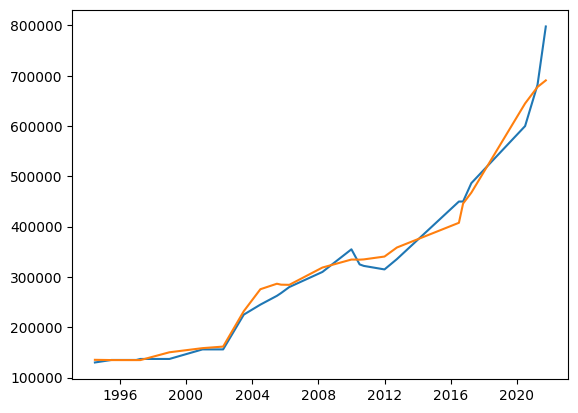

In [218]:
plot_pred_vs_actual(test, test_pred)

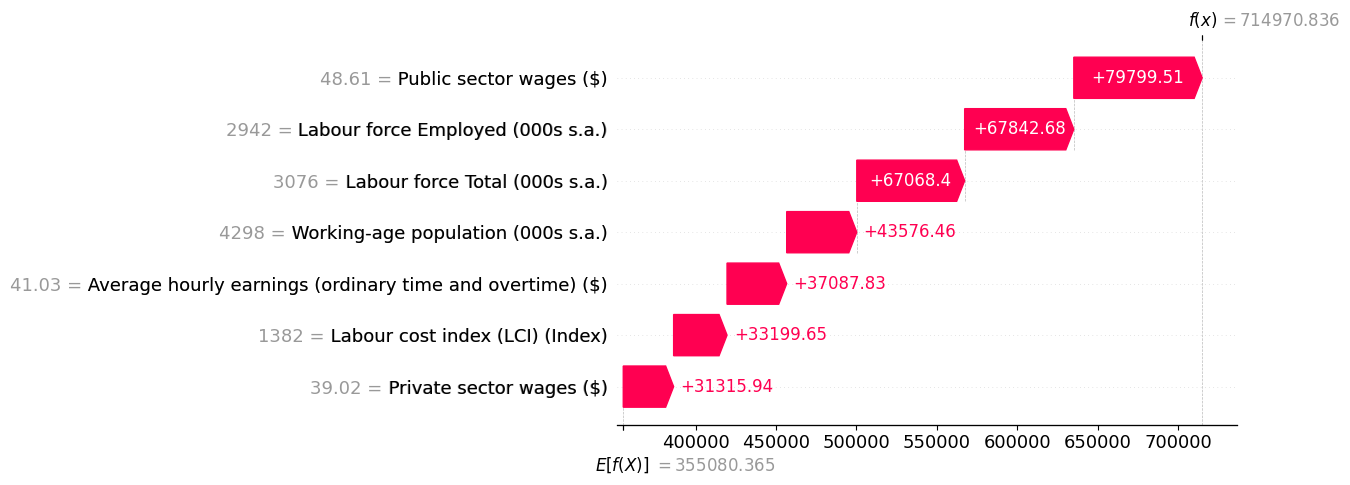

In [219]:
explainer = shap.Explainer(random_search.best_estimator_, train[shap_headers])
shap_values = explainer(df_filtered[-1:][shap_headers])
shap.waterfall_plot(shap_values[0])

---

Drop Labour force Total `(000s s.a.)`

In [220]:
shap_headers = [
    'lagged', 'Public sector wages ($)', 'Labour force Employed (000s s.a.)',
       'Working-age population (000s s.a.)',
       'Labour cost index (LCI) (Index)',
       'Average hourly earnings (ordinary time and overtime) ($)',
       'Private sector wages ($)'
]

In [221]:
gbt = GradientBoostingRegressor()

param_dist = {
    'n_estimators': np.arange(500, 5000),
    'learning_rate': np.arange(0.01, 0.4),
    'max_depth': range(1, 4),
    'loss':['squared_error'],
    'random_state':[42]
}

random_search = RandomizedSearchCV(
    estimator=gbt,            
    param_distributions=param_dist,
    n_iter=100,              
    scoring='neg_root_mean_squared_error', 
    cv=5,                      
    random_state=42,            
    n_jobs=-1,
    verbose=2                   
)

random_search.fit(train[shap_headers], train[['Nelson']])
random_search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\spong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


{'random_state': 42,
 'n_estimators': 774,
 'max_depth': 3,
 'loss': 'squared_error',
 'learning_rate': 0.01}

In [222]:
test_pred = random_search.best_estimator_.predict(test[shap_headers].sort_values(by='date'))
print_metrics(test, test_pred)

MSE: 758251603.6180787
RMSE: 27536.36874422767
MAE: 16693.759075734746
MDAE: 8954.64876452781


In [223]:
pred_last = random_search.best_estimator_.predict(df_filtered[-1:][shap_headers])
print(f'Actual value: {df_filtered[-1:].Nelson.values[0]}, Predicted value: {pred_last[0]}')

Actual value: 648000.0, Predicted value: 701207.0992988164


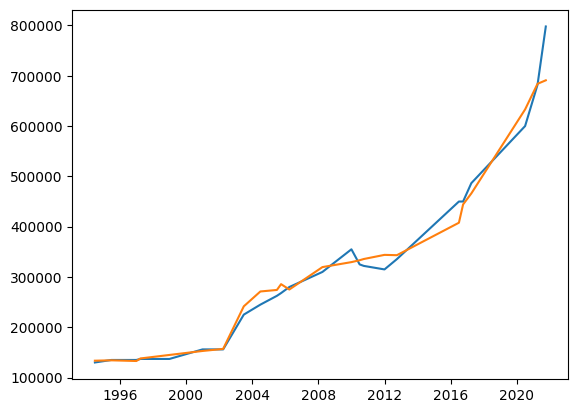

In [224]:
plot_pred_vs_actual(test, test_pred)

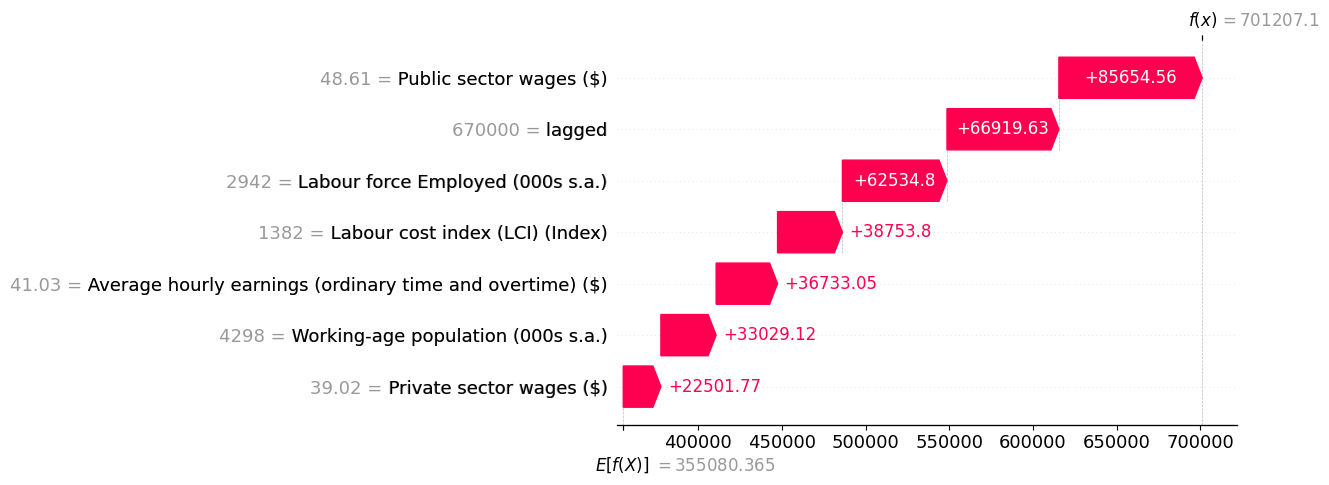

In [225]:
explainer = shap.Explainer(random_search.best_estimator_, train[shap_headers])
shap_values = explainer(df_filtered[-1:][shap_headers])
shap.waterfall_plot(shap_values[0])

----

# Random Forest Model evaluation on Wellington data - Leandri Botha

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import csv
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform

In [3]:
df_Welly= pd.read_csv('Wellington.csv')
print(df_Welly)

     Unnamed: 0        date  Wellington    lagged
0             0  1992-01-31    123000.0       NaN
1             1  1992-02-29    122000.0  123000.0
2             2  1992-03-31    125000.0  122000.0
3             3  1992-04-30    129000.0  125000.0
4             4  1992-05-31    128000.0  129000.0
..          ...         ...         ...       ...
387         387  2024-04-30    820000.0  820000.0
388         388  2024-05-31    785000.0  820000.0
389         389  2024-06-30    793000.0  785000.0
390         390  2024-07-31    765000.0  793000.0
391         391  2024-08-31    790000.0  765000.0

[392 rows x 4 columns]


In [4]:
df_Welly['date'] = pd.to_datetime(df_Welly['date'], format='%Y-%m-%d', errors='coerce')
df_Welly.set_index('date', inplace = True)

In [5]:
df_Welly = df_Welly[['Wellington', 'lagged']]
df_Welly.head()

,Wellington,lagged
date,,
1992-01-31,123000.0,NaN
1992-02-29,122000.0,123000.0
1992-03-31,125000.0,122000.0
1992-04-30,129000.0,125000.0
1992-05-31,128000.0,129000.0


<Axes: xlabel='date'>

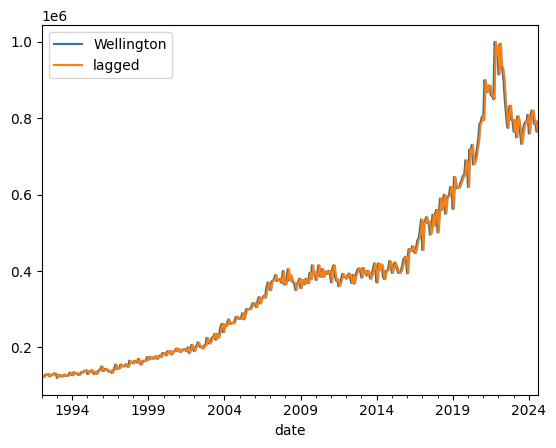

In [6]:
df_Welly.plot()

In [7]:
df_Welly

,Wellington,lagged
date,,
1992-01-31,123000.0,NaN
1992-02-29,122000.0,123000.0
1992-03-31,125000.0,122000.0
1992-04-30,129000.0,125000.0
1992-05-31,128000.0,129000.0
...,...,...
2024-04-30,820000.0,820000.0
2024-05-31,785000.0,820000.0
2024-06-30,793000.0,785000.0


In [8]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [9]:
df_expenses = pd.read_excel('House expense.xlsx')
df_expenses

,Unnamed: 0,Household net financial wealth,Household net financial wealth.1,Household net financial wealth.2,Household net wealth,Household net wealth.1,Household net wealth.2,Net equity in housing,Net equity in housing.1,Net equity in housing.2,...,Memo item: Household debt including rental properties,Memo item: Household debt including rental properties.1,Memo item: Household debt servicing (quarterly),Memo item: Household debt servicing (quarterly).1,Memo item: Household debt servicing (quarterly).2,Memo item: Household debt servicing (quarterly).3,Memo item: Household debt servicing (year ended),Memo item: Household debt servicing (year ended).1,Memo item: Household debt servicing (year ended).2,Memo item: Household debt servicing (year ended).3
0,NaN,A. Household net financial wealth (A1-A2),A1. Household financial assets,A2. Household financial liabilities,B. Household net wealth (B1+B2),B1. Household net financial wealth,B2. Housing and land value,C. Net equity in housing (C1-C2),C1. Housing and land value,C2. Housing loans,...,Household financial liabilities (including ren...,Household financial liabilities (including ren...,D. Total interest payments (D1+D2),D1. Interest payments on housing loans (in...,D2. Interest payments on consumer loans,D3. Total interest payments as a percentag...,E. Total interest payments (E1+E2),E1. Interest payments on housing loans (in...,E2. Interest payments on consumer loans,E3. Total interest payments as a percentag...
1,Notes,NaN,NaN,NaN,Yes,NaN,Yes,Yes,Yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Unit,NZDm,NZDm,NZDm,NZDm,NZDm,NZDm,NZDm,NZDm,NZDm,...,NZDm,%,NZDm,NZDm,NZDm,%,NZDm,NZDm,NZDm,%
3,Series Id,HHAL.QC5,HHAL.QA,HHAL.QB,HHAL.QC3,HHAL.QC5,HHAL.QC6,HHAL.QC2,HHAL.QC6,HHAL.QB11,...,HHAL.QM21,HHAL.QM23,HHAL.QD2.ZZH,HHAL.QD2.ZZH1,HHAL.QD2.ZZH2,HHAL.QR7.ZZH,HHAL.QD2.ZZHrt12,HHAL.QD2.ZZH1rt12,HHAL.QD2.ZZH2rt12,HHAL.QR7.ZZHrt12
4,1998-12-31 00:00:00,258766,307995,49229,435170,258766,176404,136555,176404,39849,...,65568,99,1389,1127,263,8.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2020-06-30 00:00:00,956696,1196412,239716,1885023,956696,928327,719858,928327,208469,...,315379,159,3128,2716,412,6.4,13264,11428,1836,6.7
91,2020-09-30 00:00:00,1007798,1251518,243721,1976170,1007798,968372,755476,968372,212896,...,321331,161,3016,2625,391,6,12847,11104,1743,6.4
92,2020-12-31 00:00:00,1098510,1348387,249876,2146120,1098510,1047609,828614,1047609,218995,...,330819,164,2954,2563,391,5.8,12426,10766,1660,6.2
93,2021-03-31 00:00:00,1163866,1419615,255749,2307726,1163866,1143860,918905,1143860,224955,...,340072,167,2856,2480,376,5.4,11955,10384,1571,5.9


In [10]:
df_expenses = df_expenses.drop(index=[0, 1, 2, 3], axis=1)
df_expenses

,Unnamed: 0,Household net financial wealth,Household net financial wealth.1,Household net financial wealth.2,Household net wealth,Household net wealth.1,Household net wealth.2,Net equity in housing,Net equity in housing.1,Net equity in housing.2,...,Memo item: Household debt including rental properties,Memo item: Household debt including rental properties.1,Memo item: Household debt servicing (quarterly),Memo item: Household debt servicing (quarterly).1,Memo item: Household debt servicing (quarterly).2,Memo item: Household debt servicing (quarterly).3,Memo item: Household debt servicing (year ended),Memo item: Household debt servicing (year ended).1,Memo item: Household debt servicing (year ended).2,Memo item: Household debt servicing (year ended).3
4,1998-12-31 00:00:00,258766,307995,49229,435170,258766,176404,136555,176404,39849,...,65568,99,1389,1127,263,8.2,NaN,NaN,NaN,NaN
5,1999-03-31 00:00:00,265778,316060,50282,443779,265778,178000,137048,178000,40953,...,67064,100,1337,1084,252,7.8,NaN,NaN,NaN,NaN
6,1999-06-30 00:00:00,271003,322900,51896,451398,271003,180395,138383,180395,42012,...,69124,101,1330,1078,252,7.5,NaN,NaN,NaN,NaN
7,1999-09-30 00:00:00,276606,329750,53143,457799,276606,181193,138003,181193,43190,...,70750,101,1345,1092,253,7.5,5400,4381,1019,7.7
8,1999-12-31 00:00:00,282895,337334,54439,464088,282895,181193,137115,181193,44078,...,72425,102,1383,1116,268,7.6,5394,4370,1024,7.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2020-06-30 00:00:00,956696,1196412,239716,1885023,956696,928327,719858,928327,208469,...,315379,159,3128,2716,412,6.4,13264,11428,1836,6.7
91,2020-09-30 00:00:00,1007798,1251518,243721,1976170,1007798,968372,755476,968372,212896,...,321331,161,3016,2625,391,6,12847,11104,1743,6.4
92,2020-12-31 00:00:00,1098510,1348387,249876,2146120,1098510,1047609,828614,1047609,218995,...,330819,164,2954,2563,391,5.8,12426,10766,1660,6.2
93,2021-03-31 00:00:00,1163866,1419615,255749,2307726,1163866,1143860,918905,1143860,224955,...,340072,167,2856,2480,376,5.4,11955,10384,1571,5.9


In [11]:
df_expenses.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

In [12]:
df_expenses.set_index('date', inplace = True)
df_expenses

/home/codespace/.local/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,Household net financial wealth,Household net financial wealth.1,Household net financial wealth.2,Household net wealth,Household net wealth.1,Household net wealth.2,Net equity in housing,Net equity in housing.1,Net equity in housing.2,Household disposable income,...,Memo item: Household debt including rental properties,Memo item: Household debt including rental properties.1,Memo item: Household debt servicing (quarterly),Memo item: Household debt servicing (quarterly).1,Memo item: Household debt servicing (quarterly).2,Memo item: Household debt servicing (quarterly).3,Memo item: Household debt servicing (year ended),Memo item: Household debt servicing (year ended).1,Memo item: Household debt servicing (year ended).2,Memo item: Household debt servicing (year ended).3
date,,,,,,,,,,,,,,,,,,,,,
1998-12-31,258766,307995,49229,435170,258766,176404,136555,176404,39849,16867,...,65568,99,1389,1127,263,8.2,NaN,NaN,NaN,NaN
1999-03-31,265778,316060,50282,443779,265778,178000,137048,178000,40953,17162,...,67064,100,1337,1084,252,7.8,NaN,NaN,NaN,NaN
1999-06-30,271003,322900,51896,451398,271003,180395,138383,180395,42012,17764,...,69124,101,1330,1078,252,7.5,NaN,NaN,NaN,NaN
1999-09-30,276606,329750,53143,457799,276606,181193,138003,181193,43190,17997,...,70750,101,1345,1092,253,7.5,5400,4381,1019,7.7
1999-12-31,282895,337334,54439,464088,282895,181193,137115,181193,44078,18143,...,72425,102,1383,1116,268,7.6,5394,4370,1024,7.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30,956696,1196412,239716,1885023,956696,928327,719858,928327,208469,49073,...,315379,159,3128,2716,412,6.4,13264,11428,1836,6.7
2020-09-30,1007798,1251518,243721,1976170,1007798,968372,755476,968372,212896,50467,...,321331,161,3016,2625,391,6,12847,11104,1743,6.4
2020-12-31,1098510,1348387,249876,2146120,1098510,1047609,828614,1047609,218995,51247,...,330819,164,2954,2563,391,5.8,12426,10766,1660,6.2


In [13]:
df_expenses.reset_index(drop = True)

,Household net financial wealth,Household net financial wealth.1,Household net financial wealth.2,Household net wealth,Household net wealth.1,Household net wealth.2,Net equity in housing,Net equity in housing.1,Net equity in housing.2,Household disposable income,...,Memo item: Household debt including rental properties,Memo item: Household debt including rental properties.1,Memo item: Household debt servicing (quarterly),Memo item: Household debt servicing (quarterly).1,Memo item: Household debt servicing (quarterly).2,Memo item: Household debt servicing (quarterly).3,Memo item: Household debt servicing (year ended),Memo item: Household debt servicing (year ended).1,Memo item: Household debt servicing (year ended).2,Memo item: Household debt servicing (year ended).3
0,258766,307995,49229,435170,258766,176404,136555,176404,39849,16867,...,65568,99,1389,1127,263,8.2,NaN,NaN,NaN,NaN
1,265778,316060,50282,443779,265778,178000,137048,178000,40953,17162,...,67064,100,1337,1084,252,7.8,NaN,NaN,NaN,NaN
2,271003,322900,51896,451398,271003,180395,138383,180395,42012,17764,...,69124,101,1330,1078,252,7.5,NaN,NaN,NaN,NaN
3,276606,329750,53143,457799,276606,181193,138003,181193,43190,17997,...,70750,101,1345,1092,253,7.5,5400,4381,1019,7.7
4,282895,337334,54439,464088,282895,181193,137115,181193,44078,18143,...,72425,102,1383,1116,268,7.6,5394,4370,1024,7.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,956696,1196412,239716,1885023,956696,928327,719858,928327,208469,49073,...,315379,159,3128,2716,412,6.4,13264,11428,1836,6.7
87,1007798,1251518,243721,1976170,1007798,968372,755476,968372,212896,50467,...,321331,161,3016,2625,391,6,12847,11104,1743,6.4
88,1098510,1348387,249876,2146120,1098510,1047609,828614,1047609,218995,51247,...,330819,164,2954,2563,391,5.8,12426,10766,1660,6.2
89,1163866,1419615,255749,2307726,1163866,1143860,918905,1143860,224955,52570,...,340072,167,2856,2480,376,5.4,11955,10384,1571,5.9


In [14]:
df_expenses.isna()

,Household net financial wealth,Household net financial wealth.1,Household net financial wealth.2,Household net wealth,Household net wealth.1,Household net wealth.2,Net equity in housing,Net equity in housing.1,Net equity in housing.2,Household disposable income,...,Memo item: Household debt including rental properties,Memo item: Household debt including rental properties.1,Memo item: Household debt servicing (quarterly),Memo item: Household debt servicing (quarterly).1,Memo item: Household debt servicing (quarterly).2,Memo item: Household debt servicing (quarterly).3,Memo item: Household debt servicing (year ended),Memo item: Household debt servicing (year ended).1,Memo item: Household debt servicing (year ended).2,Memo item: Household debt servicing (year ended).3
date,,,,,,,,,,,,,,,,,,,,,
1998-12-31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,True,True
1999-03-31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,True,True
1999-06-30,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,True,True
1999-09-30,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1999-12-31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-09-30,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-12-31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [15]:
welly_expenses = df_Welly.merge(df_expenses, on= 'date', how = 'inner' )

In [16]:
welly_expenses.dropna().head(5)

,Wellington,lagged,Household net financial wealth,Household net financial wealth.1,Household net financial wealth.2,Household net wealth,Household net wealth.1,Household net wealth.2,Net equity in housing,Net equity in housing.1,...,Memo item: Household debt including rental properties,Memo item: Household debt including rental properties.1,Memo item: Household debt servicing (quarterly),Memo item: Household debt servicing (quarterly).1,Memo item: Household debt servicing (quarterly).2,Memo item: Household debt servicing (quarterly).3,Memo item: Household debt servicing (year ended),Memo item: Household debt servicing (year ended).1,Memo item: Household debt servicing (year ended).2,Memo item: Household debt servicing (year ended).3
date,,,,,,,,,,,,,,,,,,,,,
2000-03-31,179000.0,185000.0,287245,342476,55231,469165,287245,181920,137066,181920,...,73533,102,1466,1191,275,8.1,5523,4477,1047,7.7
2001-03-31,190000.0,188000.0,291402,350838,59436,477998,291402,186596,139045,186596,...,78820,110,1684,1361,323,9.3,6566,5327,1239,9.2
2002-03-31,204500.0,200000.0,299288,363901,64613,500170,299288,200881,149610,200881,...,85524,113,1584,1254,329,8.3,6492,5179,1313,8.6
2003-03-31,225500.0,215000.0,308597,381078,72481,542511,308597,233914,177111,233914,...,95686,124,1855,1479,376,9.4,7111,5660,1452,9.2
2004-03-31,262000.0,255000.0,359757,443392,83635,662432,359757,302675,236235,302675,...,110845,131,2035,1631,404,9.4,7722,6157,1565,9.2


In [17]:
welly_expenses.head()

,Wellington,lagged,Household net financial wealth,Household net financial wealth.1,Household net financial wealth.2,Household net wealth,Household net wealth.1,Household net wealth.2,Net equity in housing,Net equity in housing.1,...,Memo item: Household debt including rental properties,Memo item: Household debt including rental properties.1,Memo item: Household debt servicing (quarterly),Memo item: Household debt servicing (quarterly).1,Memo item: Household debt servicing (quarterly).2,Memo item: Household debt servicing (quarterly).3,Memo item: Household debt servicing (year ended),Memo item: Household debt servicing (year ended).1,Memo item: Household debt servicing (year ended).2,Memo item: Household debt servicing (year ended).3
date,,,,,,,,,,,,,,,,,,,,,
1998-12-31,175000.0,165000.0,258766,307995,49229,435170,258766,176404,136555,176404,...,65568,99,1389,1127,263,8.2,NaN,NaN,NaN,NaN
1999-03-31,170000.0,175000.0,265778,316060,50282,443779,265778,178000,137048,178000,...,67064,100,1337,1084,252,7.8,NaN,NaN,NaN,NaN
1999-06-30,175000.0,170000.0,271003,322900,51896,451398,271003,180395,138383,180395,...,69124,101,1330,1078,252,7.5,NaN,NaN,NaN,NaN
1999-09-30,175000.0,170000.0,276606,329750,53143,457799,276606,181193,138003,181193,...,70750,101,1345,1092,253,7.5,5400,4381,1019,7.7
1999-12-31,185000.0,175000.0,282895,337334,54439,464088,282895,181193,137115,181193,...,72425,102,1383,1116,268,7.6,5394,4370,1024,7.6


# EDA

In [18]:
train, test = train_test_split(df_Welly, test_size = 0.2, shuffle = True)

In [19]:
train

,Wellington,lagged
date,,
2010-05-31,385000.0,388000.0
2015-02-28,410000.0,395000.0
2006-02-28,305500.0,313000.0
1997-12-31,160000.0,162000.0
2018-11-30,620000.0,598000.0
...,...,...
2014-04-30,416960.0,402000.0
2006-06-30,327000.0,315000.0
2011-07-31,360000.0,377500.0


In [20]:
test

,Wellington,lagged
date,,
2018-05-31,580000.0,560000.0
1998-10-31,164000.0,165000.0
2003-10-31,255000.0,237000.0
2022-12-31,795000.0,796000.0
2021-05-31,885000.0,868000.0
...,...,...
2022-06-30,848000.0,900000.0
2020-02-29,718000.0,620000.0
2011-09-30,380000.0,367500.0


In [21]:
random_param_grid = {
    'n_estimators': 200,
    'max_depth':  10,
    'max_samples': 0.8
    
}

In [22]:
rf_model = RandomForestRegressor(**random_param_grid)

In [23]:
rf_model.fit(train[['lagged']], train[['Wellington']])

/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=10, max_samples=0.8, n_estimators=200)

In [24]:
rf_pred = rf_model.predict(train[['lagged']])

In [25]:
mae = mean_absolute_error(rf_pred, train.Wellington)
print(mae)
mse = mean_squared_error(rf_pred, train.Wellington)
print(mse)
rmse = r2_score(rf_pred, train.Wellington)
print(rmse)

8860.529595384865
174935561.4098509
0.9964820882176418


In [26]:
train.index

DatetimeIndex(['2010-05-31', '2015-02-28', '2006-02-28', '1997-12-31',
               '2018-11-30', '2011-01-31', '2013-05-31', '2010-12-31',
               '2014-12-31', '1994-06-30',
               ...
               '2014-02-28', '1993-08-31', '2010-08-31', '2012-11-30',
               '2001-02-28', '2014-04-30', '2006-06-30', '2011-07-31',
               '2017-04-30', '2006-08-31'],
              dtype='datetime64[ns]', name='date', length=313, freq=None)

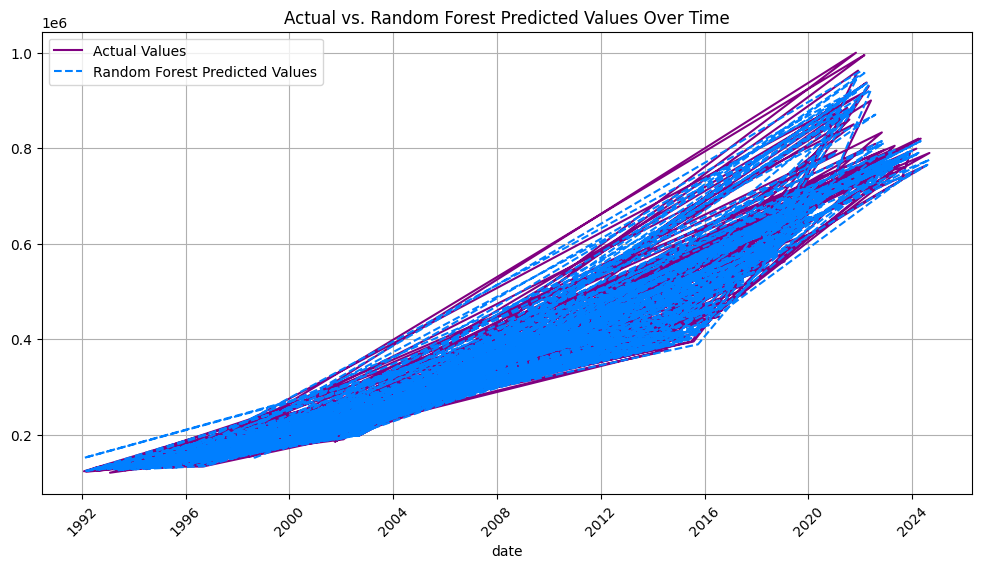

In [27]:
from matplotlib import pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(train.index, train.Wellington ,label='Actual Values', linestyle='-', color = 'purple')
plt.plot(train.index, rf_pred, label='Random Forest Predicted Values', linestyle='--', color = '#007FFF')
plt.xlabel('date')
plt.title('Actual vs. Random Forest Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [28]:
test_pred = rf_model.predict(test[['lagged']])

In [29]:
mae_test = mean_absolute_error(test_pred, test.Wellington)
print(mae_test)
mse_test = mean_squared_error(test_pred, test.Wellington)
print(mse_test)
rmse_test = r2_score(test_pred, test.Wellington)
print(rmse_test)

17826.68381559941
896396461.276295
0.9813713848990413


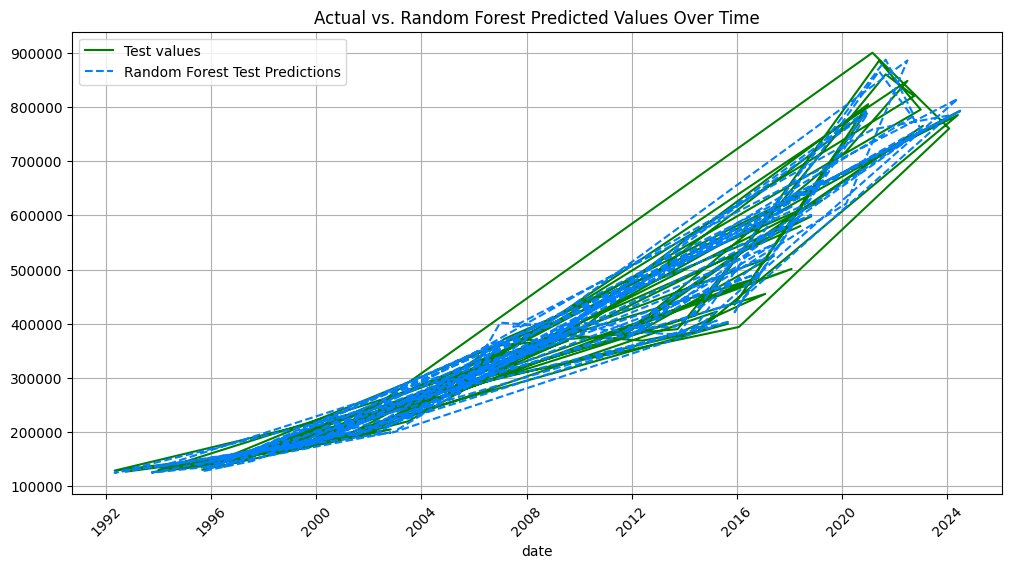

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.Wellington ,label='Test values', linestyle='-', color = 'green')
plt.plot(test.index, test_pred, label='Random Forest Test Predictions', linestyle='--', color = '#007FFF')
plt.xlabel('date')
plt.title('Actual vs. Random Forest Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [31]:
train = df_Welly[:-30].dropna()

In [32]:
test = df_Welly[-30:].dropna()

In [33]:
rf_model.fit(train[['lagged']], train[['Wellington']])

/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=10, max_samples=0.8, n_estimators=200)

In [34]:
pred = rf_model.predict(train[['lagged']])

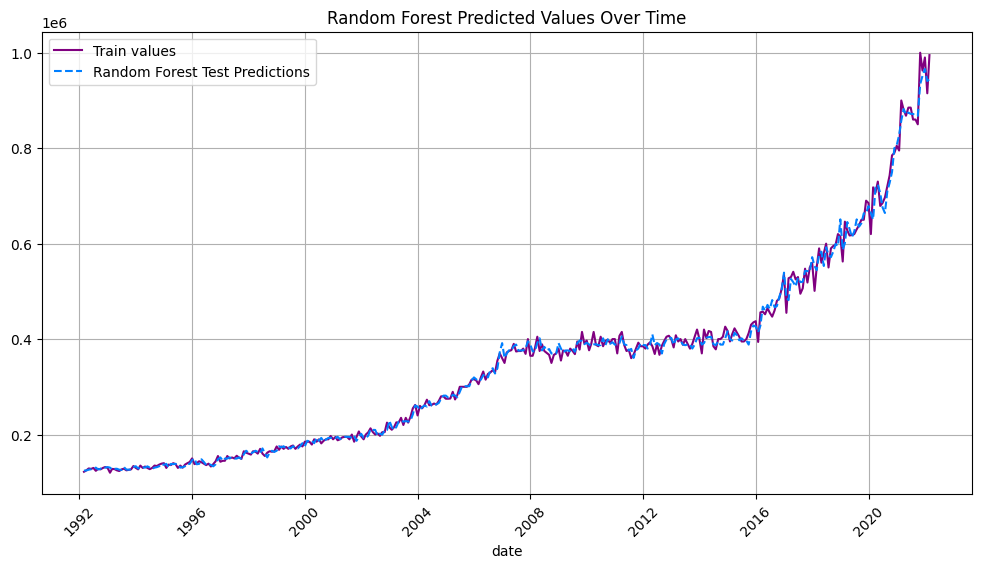

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.Wellington ,label='Train values', linestyle='-', color = 'purple')
plt.plot(train.index, pred, label='Random Forest Predictions', linestyle='--', color = '#007FFF')
plt.xlabel('date')
plt.title('Random Forest Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [36]:
mae = mean_absolute_error(pred, train.Wellington)
print(mae)
mse = mean_squared_error(pred, train.Wellington)
print(mse)
rmse = r2_score(pred, train.Wellington)
print(rmse)

8861.474797540792
176671590.96042404
0.9952329468268614


In [36]:
test_pred = rf_model.predict(test[['lagged']])

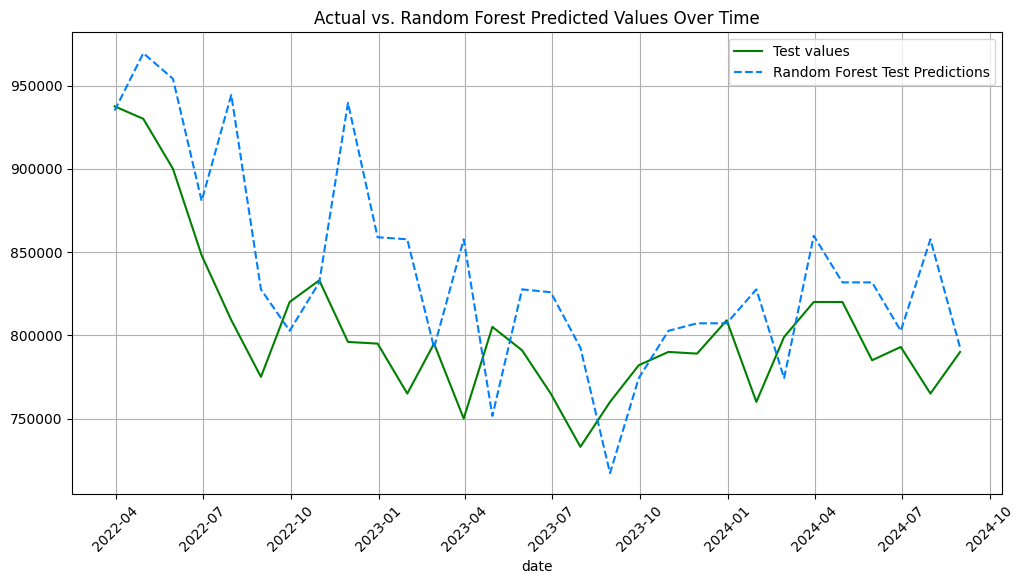

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.Wellington ,label='Test values', linestyle='-', color = 'green')
plt.plot(test.index, test_pred, label='Random Forest Test Predictions', linestyle='--', color = '#007FFF')
plt.xlabel('date')
plt.title('Actual vs. Random Forest Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [38]:
mae_test = mean_absolute_error(test_pred, test.Wellington)
print(mae_test)
mse_test = mean_squared_error(test_pred, test.Wellington)
print(mse_test)
rmse_test = r2_score(test_pred, test.Wellington)
print(rmse_test)

44481.73972222221
3446251776.5013304
0.04515277328799372


In [39]:
random_param_grid2 = {
    'n_estimators': (100, 200, 500),
    'max_depth':  (5, 10, 20),
    'min_samples_split': (2, 5, 10),
    'min_samples_leaf': (1, 2, 5, 10),
    'max_leaf_nodes': (10, 20, 50)
    
}

In [40]:
from sklearn.model_selection import RandomizedSearchCV


random_search = RandomizedSearchCV(estimator = rf_model, param_distributions = random_param_grid2, n_iter = 200, cv = 5, random_state = 42, n_jobs = -1)

In [41]:
rf_search = random_search.fit(train[['lagged']], train['Wellington'].values)
rf_search.best_params_

/home/codespace/.python/current/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 50,
 'max_depth': 20}

In [42]:
test_search_pred = rf_search.best_estimator_.predict(test[['lagged']])

In [43]:
mae_search = mean_absolute_error(test_search_pred, test.Wellington)
print(mae_search)
mse_search = mean_squared_error(test_search_pred, test.Wellington)
print(mse_search)
rmse_search = r2_score(test_search_pred, test.Wellington)
print(rmse_search)

41154.001044312325
2519017178.4667954
-0.0181431064211679


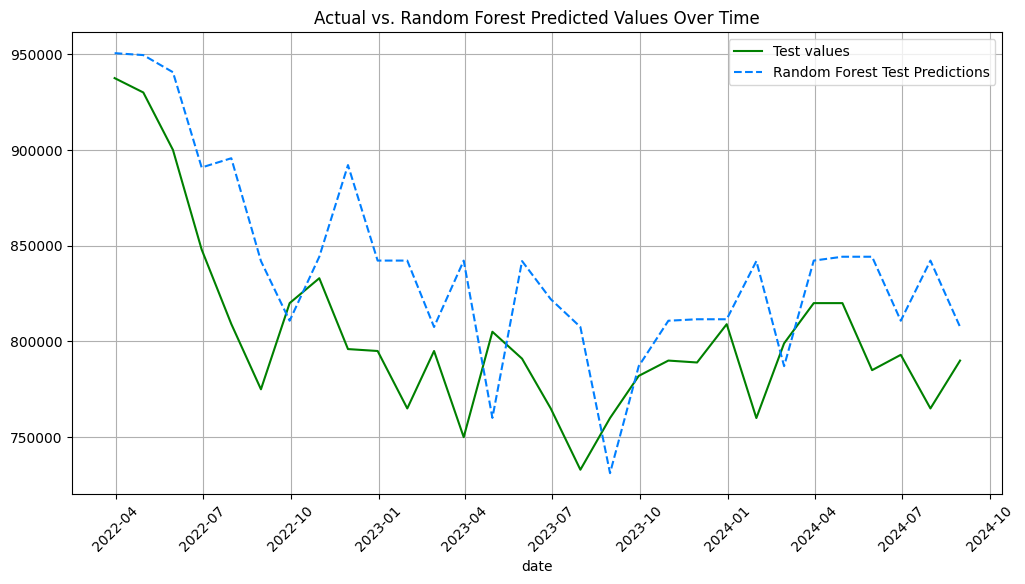

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.Wellington ,label='Test values', linestyle='-', color = 'green')
plt.plot(test.index, test_search_pred, label='Random Forest Test Predictions', linestyle='--', color = '#007FFF')
plt.xlabel('date')
plt.title('Actual vs. Random Forest Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Wellington expenses EDA

In [45]:
welly_expenses = welly_expenses.apply(pd.to_numeric, errors='coerce')

In [46]:
random_params = {
    'n_estimators': 200,
    'max_depth':  5,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'max_leaf_nodes': 10,
    'random_state': 42
    
}

In [47]:
rf_model2 = RandomForestRegressor(**random_params)

In [48]:
train, test = train_test_split(welly_expenses, test_size=0.2, shuffle=False)

In [49]:
rf_model2.fit(train.drop(columns = ['Wellington']), train.Wellington)

RandomForestRegressor(max_depth=5, max_leaf_nodes=10, min_samples_leaf=2,
                      n_estimators=200, random_state=42)

In [50]:
welly_pred = rf_model2.predict(train.drop(columns = ['Wellington']))

In [51]:
mae2 = mean_absolute_error(welly_pred, train.Wellington)
print(mae2)
mse2 = mean_squared_error(welly_pred, train.Wellington)
print(mse2)
rmse2 = r2_score(welly_pred, train.Wellington)
print(rmse2)

4443.713136002314
39400128.841074824
0.9951824677167682


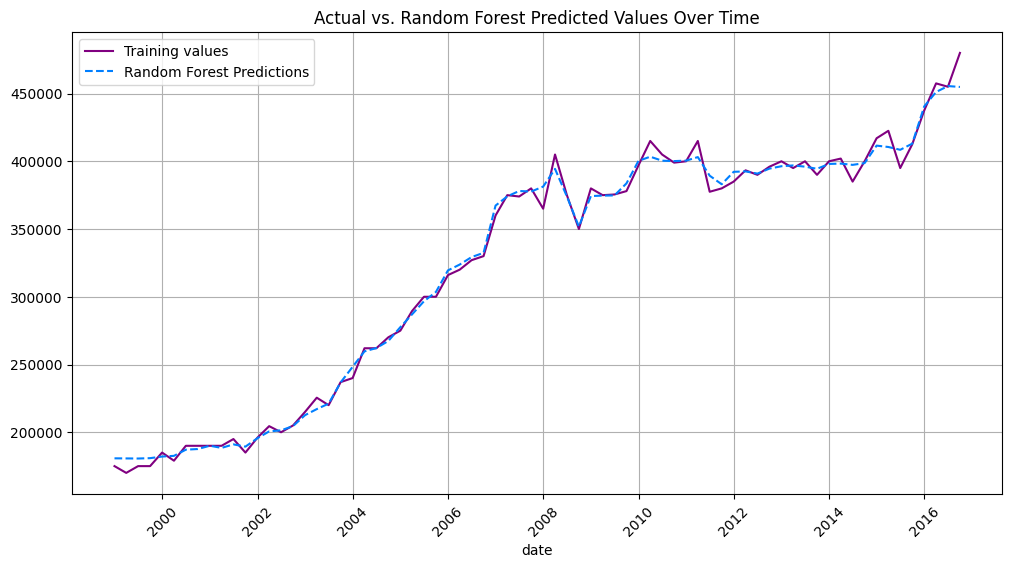

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.Wellington ,label='Training values', linestyle='-', color = 'purple')
plt.plot(train.index, welly_pred, label='Random Forest Predictions', linestyle='--', color = '#007FFF')
plt.xlabel('date')
plt.title('Actual vs. Random Forest Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [53]:
welly_test_pred = rf_model2.predict(test.drop(columns = ['Wellington']))

In [54]:
mae_test2 = mean_absolute_error(welly_test_pred, test.Wellington)
print(mae_test2)
mse_test2 = mean_squared_error(welly_test_pred, test.Wellington)
print(mse_test2)
rmse_test2 = r2_score(welly_test_pred, test.Wellington)
print(rmse_test2)

198544.16005497248
51642745261.40859
-1546.4139315025147


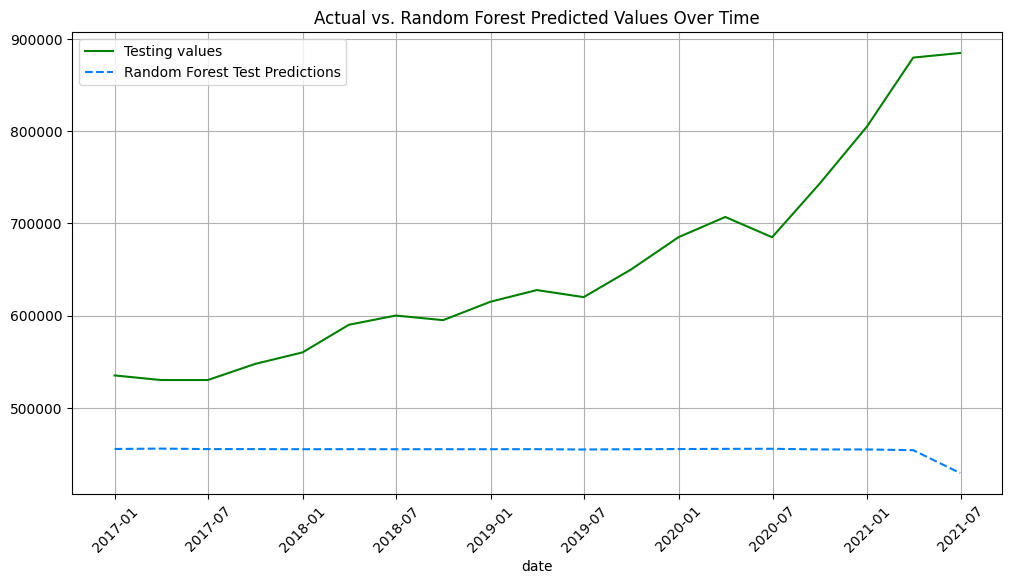

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.Wellington ,label='Testing values', linestyle='-', color = 'green')
plt.plot(test.index, welly_test_pred, label='Random Forest Test Predictions', linestyle='--', color = '#007FFF')
plt.xlabel('date')
plt.title('Actual vs. Random Forest Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [56]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.


In [57]:
import shap

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


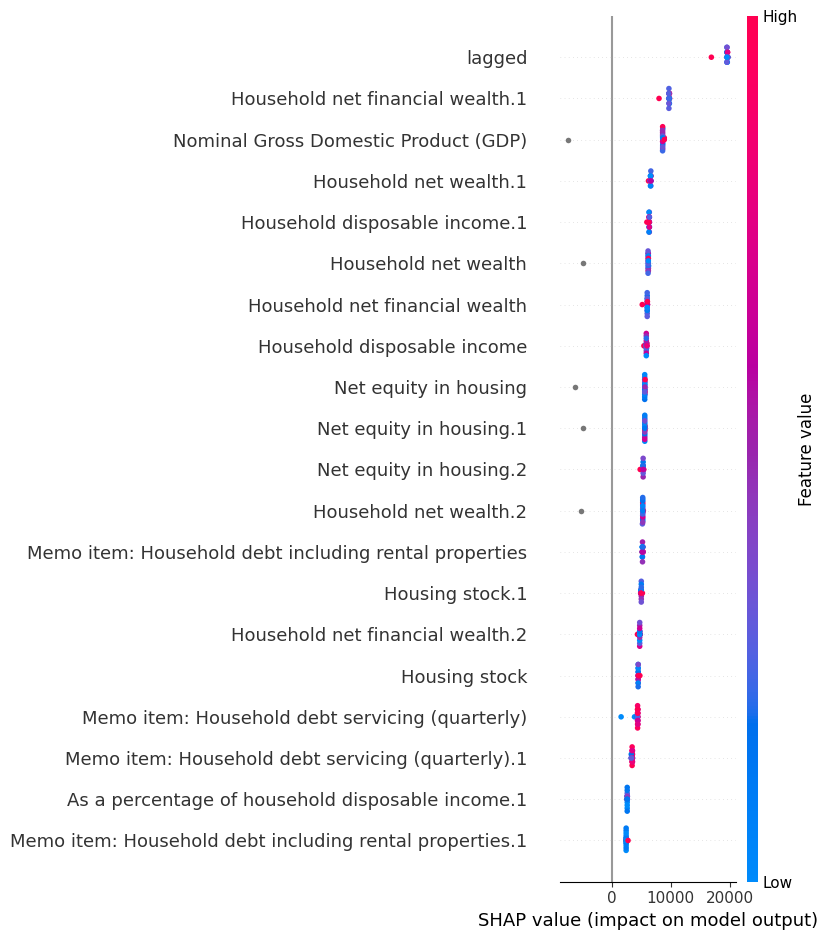

In [58]:
explainer = shap.Explainer(rf_model2, train.drop(columns = ['Wellington']))
shap_values = explainer.shap_values(test.drop(columns = ['Wellington']))
shap.summary_plot(shap_values, test.drop(columns = ['Wellington']))

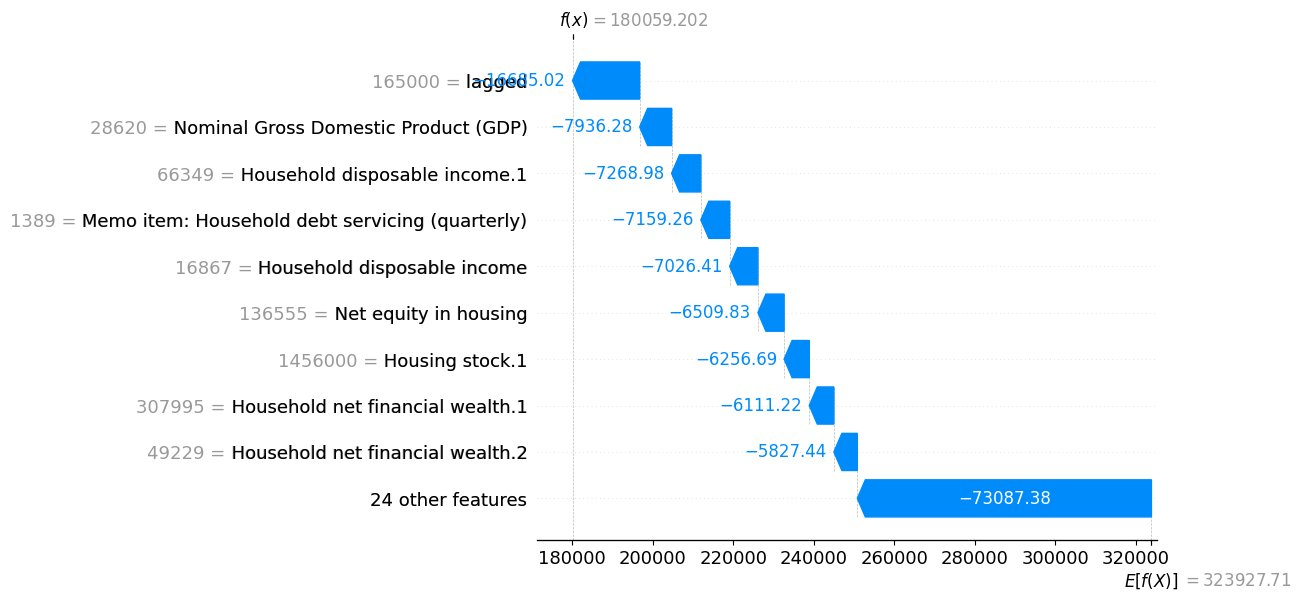

In [59]:
shap_values = explainer(welly_expenses.drop(columns='Wellington'))
shap.waterfall_plot(shap_values[0])

In [60]:
shap_head = [ 
    "Household net financial wealth.1",
    "Nominal Gross Domestic Product (GDP)",
    "Household net wealth.1",
    "Household disposable income.1",
    "Household net wealth",
    "Household net financial wealth",
    "Household disposable income",
    "Net equity in housing",
    "Net equity in housing.1",
    "Net equity in housing.2",
    "Household net wealth.2",
    "Memo item: Household debt including rental properties",
    "Housing stock.1",
    "Household net financial wealth.2",
    "Housing stock",
    "Memo item: Household debt servicing (quarterly)",
    "Memo item: Household debt servicing (quarterly).1",
    "As a percentage of household disposable income.1",
    "Memo item: Household debt including rental properties.1",
    "lagged",
    "Wellington"

]

In [61]:
random_params = {
    'n_estimators': 200,
    'max_depth':  5,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'max_leaf_nodes': 10,
    'random_state': 42
    
}

In [62]:
rf_model2 = RandomForestRegressor(**random_params)

In [63]:
train, test = train_test_split(welly_expenses[shap_head], test_size=0.2, shuffle=False)

In [64]:
rf_model2.fit(train.drop(columns = ['Wellington']), train.Wellington)

RandomForestRegressor(max_depth=5, max_leaf_nodes=10, min_samples_leaf=2,
                      n_estimators=200, random_state=42)

In [65]:
welly_pred = rf_model2.predict(train.drop(columns = ['Wellington']))

In [66]:
mae2 = mean_absolute_error(welly_pred, train.Wellington)
print(mae2)
mse2 = mean_squared_error(welly_pred, train.Wellington)
print(mse2)
rmse2 = r2_score(welly_pred, train.Wellington)
print(rmse2)

4564.00158416468
39964153.25037649
0.9951196642611536


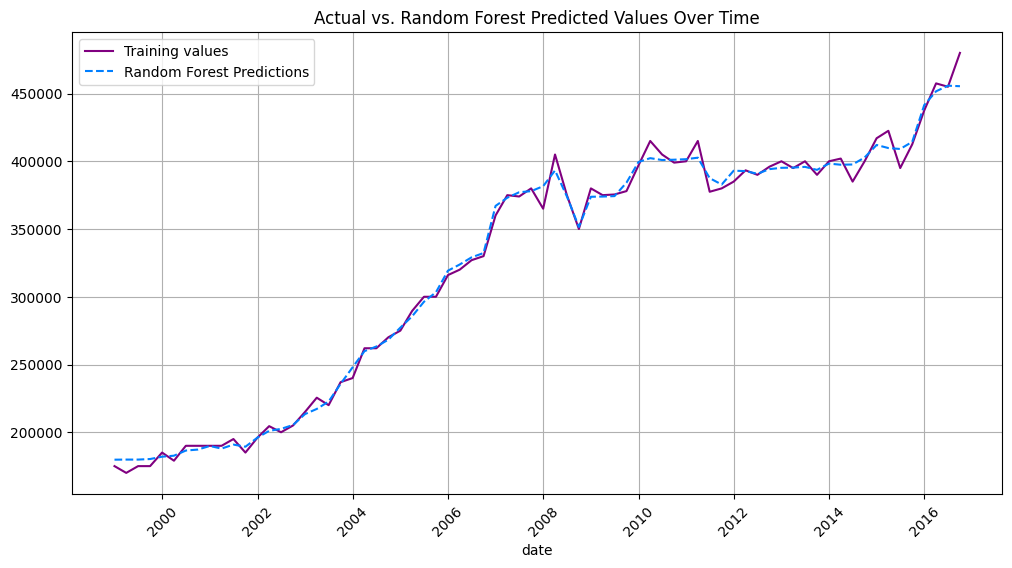

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.Wellington ,label='Training values', linestyle='-', color = 'purple')
plt.plot(train.index, welly_pred, label='Random Forest Predictions', linestyle='--', color = '#007FFF')
plt.xlabel('date')
plt.title('Actual vs. Random Forest Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [68]:
welly_test_pred = rf_model2.predict(test.drop(columns = ['Wellington']))

In [69]:
mae_test2 = mean_absolute_error(welly_test_pred, test.Wellington)
print(mae_test2)
mse_test2 = mean_squared_error(welly_test_pred, test.Wellington)
print(mse_test2)
rmse_test2 = r2_score(welly_test_pred, test.Wellington)
print(rmse_test2)

198298.2455062286
51504508388.07782
-1722.405919553531


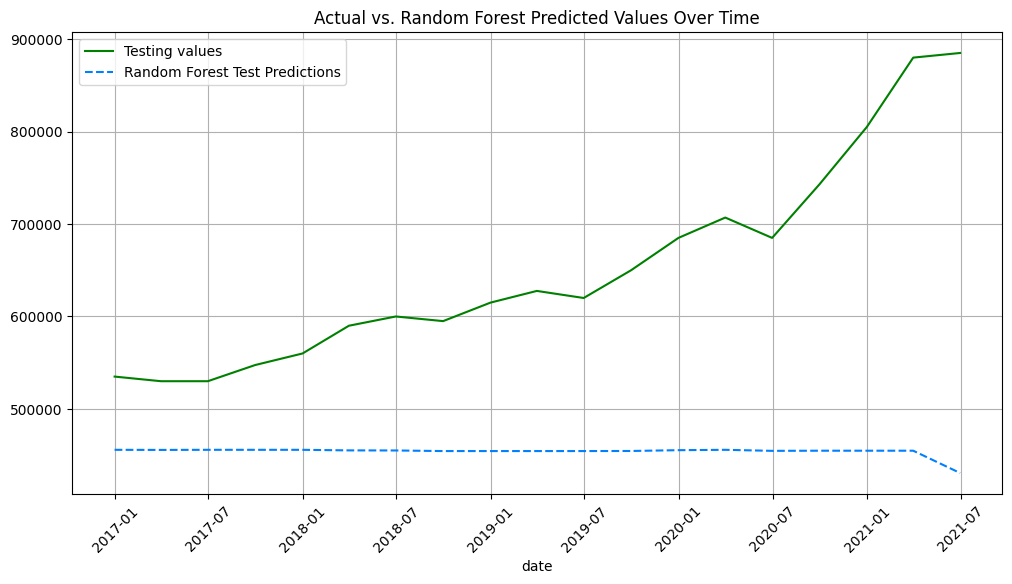

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.Wellington ,label='Testing values', linestyle='-', color = 'green')
plt.plot(test.index, welly_test_pred, label='Random Forest Test Predictions', linestyle='--', color = '#007FFF')
plt.xlabel('date')
plt.title('Actual vs. Random Forest Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Feature engineering

In [71]:
train, test = train_test_split(
    welly_expenses[["Household net financial wealth.1", "Nominal Gross Domestic Product (GDP)", 'Wellington', 'lagged']].fillna(0), 
    test_size=0.2, shuffle=False
)

In [72]:
X_train = train[["Household net financial wealth.1", "Nominal Gross Domestic Product (GDP)", 'Wellington']]
y_train = train['lagged']
X_test = test[["Household net financial wealth.1", "Nominal Gross Domestic Product (GDP)", 'Wellington']]
y_test = test['lagged']

In [73]:
params = {
    'n_estimators': randint(50, 200),  
    'max_depth': randint(1, 20),       
    'min_samples_split': randint(2, 20), 
    'min_samples_leaf': randint(1, 10),  
    'max_features': ['auto', 'sqrt', 'log2'], 
    'bootstrap': [True, False]  
}

In [74]:
rf_model = RandomForestRegressor(**params)

In [75]:
random_search = RandomizedSearchCV(estimator = rf_model,
                                   param_distributions = params,
                                   n_iter = 100,
                                   cv = 5,
                                   verbose = 2,
                                   random_state = 42,
                                   n_jobs = -1)

In [76]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.3s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.3s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.3s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.3s
[CV] END bootstrap=True, max_depth=11, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=153; total time=   0.2s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.2s
[CV] END bootstrap=True, max_depth=11, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=153; tota

/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
210 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
126 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/hom

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(bootstrap=[True, False],
                                                   max_depth=<scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f74d71b8380>,
                                                   max_features=['auto', 'sqrt',
                                                                 'log2'],
                                                   min_samples_leaf=<scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f74e62c4320>,
                                                   min_samples_split=<scipy.stats._distn_infrastructure.r...
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f74e62c4320>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f74d71b98b0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f74d71bbb30>},
                   random_state=42, verbose=2)

In [77]:
train_pred = random_search.predict(X_train)

In [78]:
mae = mean_absolute_error(train_pred, y_train)
print(mae)
mse = mean_squared_error(train_pred, y_train)
print(mse)
rmse = r2_score(train_pred, y_train)
print(rmse)

7738.54664411534
91613633.950215
0.9886733479592272


In [79]:
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 99}


In [80]:
best_rf_model = random_search.best_estimator_

In [81]:
test_pred = random_search.predict(X_test)

In [82]:
mae = mean_absolute_error(test_pred, y_test)
print(mae)
mse = mean_squared_error(test_pred, y_test)
print(mse)
rmse = r2_score(test_pred, y_test)
print(rmse)

204055.57431913272
58185919645.342186
-98.74508844782119


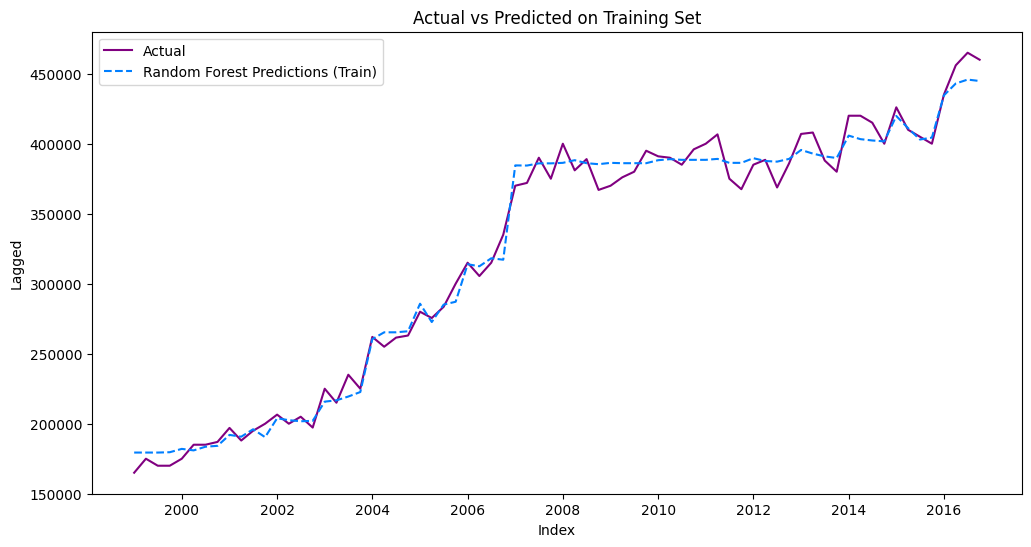

In [83]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, y_train.values, label='Actual', linestyle='-', color='purple')
plt.plot(train.index, train_pred, label='Random Forest Predictions (Train)', linestyle='--', color='#007FFF')
plt.xlabel('Index')
plt.ylabel('Lagged')
plt.title('Actual vs Predicted on Training Set')
plt.legend()
plt.show()

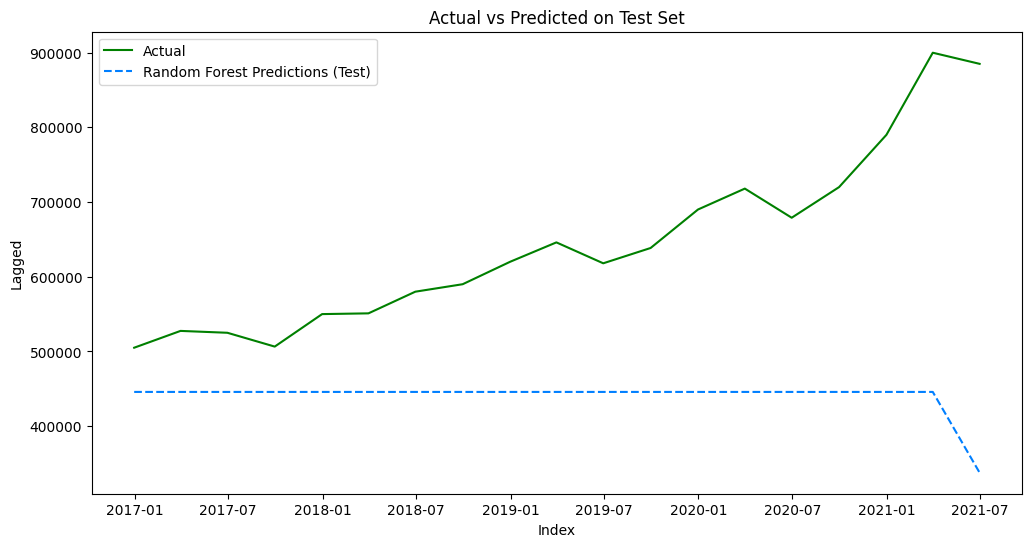

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test.values, label='Actual', linestyle='-', color='green')
plt.plot(test.index, test_pred, label='Random Forest Predictions (Test)', linestyle='--', color='#007FFF')
plt.xlabel('Index')
plt.ylabel('Lagged')
plt.title('Actual vs Predicted on Test Set')
plt.legend()
plt.show()


# Lagged Features

In [85]:
welly_expenses['Household_net_lag1'] = welly_expenses['Household net financial wealth.1'].shift(1)
welly_expenses['Household_net_lag3'] = welly_expenses['Household net financial wealth.1'].shift(3)
welly_expenses['GDP_lag1'] = welly_expenses['Nominal Gross Domestic Product (GDP)'].shift(1)
welly_expenses['GDP_lag3'] = welly_expenses['Nominal Gross Domestic Product (GDP)'].shift(3)

In [86]:
train, test = train_test_split(welly_expenses.fillna(0), test_size=0.2, shuffle=False)

In [87]:
X_train = train[['Household_net_lag1', 'Household_net_lag3', 'Wellington']]
y_train = train['lagged']
X_test = test[['Household_net_lag1', 'Household_net_lag3', 'Wellington']]
y_test = test['lagged']

In [88]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [89]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [90]:
rf_model = RandomForestRegressor(**params)

In [91]:
random_search = RandomizedSearchCV(estimator = rf_model,
                                   param_distributions = params,
                                   n_iter = 100,
                                   cv = 5,
                                   verbose = 2,
                                   random_state = 42,
                                   n_jobs = -1)

In [92]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.3s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.3s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.3s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.3s
[CV] END bootstrap=True, max_depth=11, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=153; total time=   0.2s
[CV] END bootstrap=True, max_depth=11, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=153; total time=   0.2s
[CV] END bootstrap=True, max_depth=11, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=153; tota

/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
210 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
121 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/hom

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(bootstrap=[True, False],
                                                   max_depth=<scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f74d71b8380>,
                                                   max_features=['auto', 'sqrt',
                                                                 'log2'],
                                                   min_samples_leaf=<scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f74e62c4320>,
                                                   min_samples_split=<scipy.stats._distn_infrastructure.r...
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f74e62c4320>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f74d71b98b0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f74d71bbb30>},
                   random_state=42, verbose=2)

In [93]:
train_pred = random_search.predict(X_train)

In [94]:
mae = mean_absolute_error(train_pred, y_train)
print(mae)
mse = mean_squared_error(train_pred, y_train)
print(mse)
rmse = r2_score(train_pred, y_train)
print(rmse)

7202.626281700392
81197820.75177246
0.9901744196702942


In [95]:
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'bootstrap': False, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 145}


In [96]:
best_rf_model = random_search.best_estimator_

In [97]:
test_pred = random_search.predict(X_test)

In [98]:
mae = mean_absolute_error(test_pred, y_test)
print(mae)
mse = mean_squared_error(test_pred, y_test)
print(mse)
rmse = r2_score(test_pred, y_test)
print(rmse)

190178.94736842104
49390029473.68421
0.0


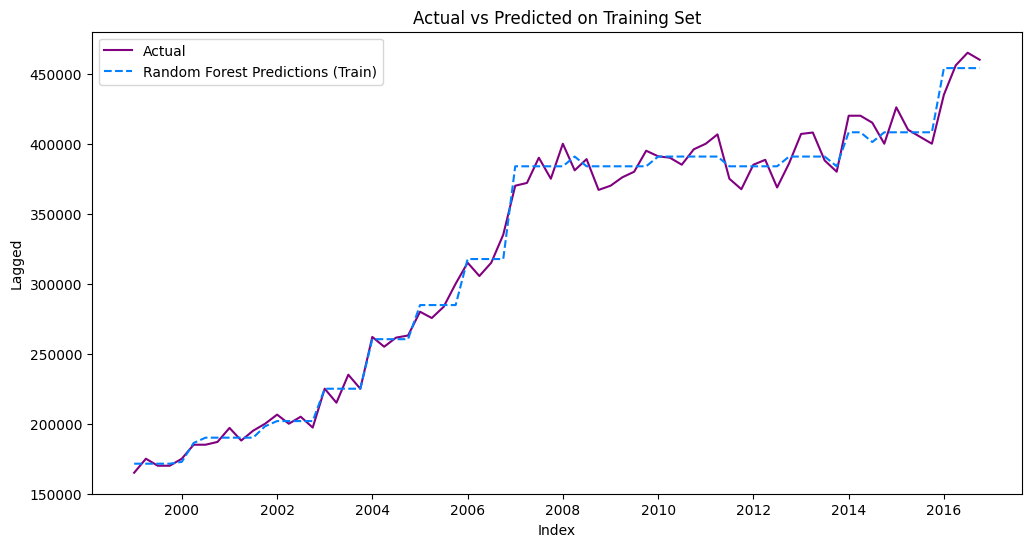

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, y_train.values, label='Actual', linestyle='-', color='purple')
plt.plot(train.index, train_pred, label='Random Forest Predictions (Train)', linestyle='--', color='#007FFF')
plt.xlabel('Index')
plt.ylabel('Lagged')
plt.title('Actual vs Predicted on Training Set')
plt.legend()
plt.show()

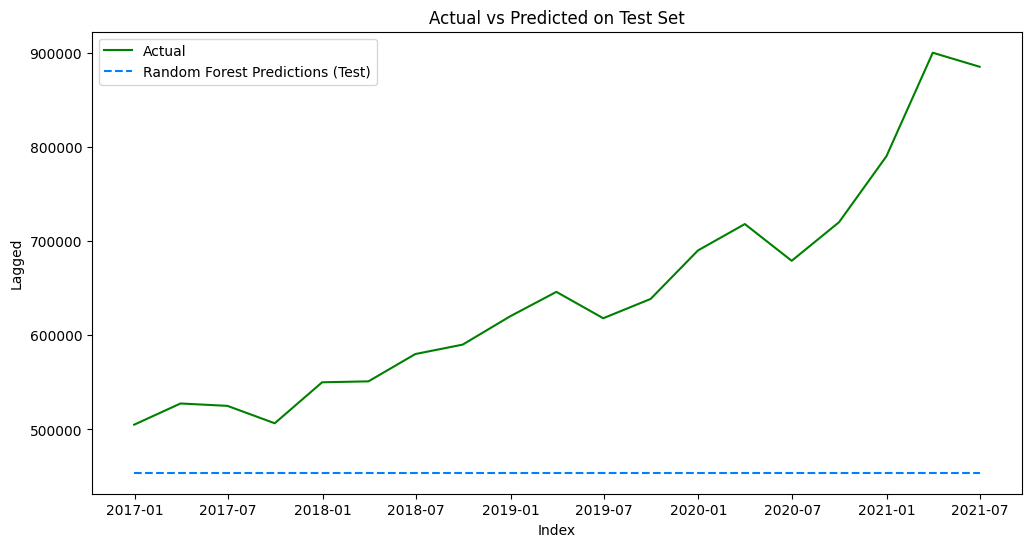

In [100]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test.values, label='Actual', linestyle='-', color='green')
plt.plot(test.index, test_pred, label='Random Forest Predictions (Test)', linestyle='--', color='#007FFF')
plt.xlabel('Index')
plt.ylabel('Lagged')
plt.title('Actual vs Predicted on Test Set')
plt.legend()
plt.show()

# Rolling averages

In [101]:
welly_expenses['Household_net_SMA3'] = welly_expenses['Household net financial wealth.1'].rolling(window=3).mean()
welly_expenses['GDP_SMA3'] = welly_expenses['Nominal Gross Domestic Product (GDP)'].rolling(window=3).mean()

In [102]:
train, test = train_test_split(welly_expenses.fillna(0), test_size=0.2, shuffle=False)

In [103]:
X_train = train[['Household_net_SMA3','Wellington']]
y_train = train['lagged']
X_test = test[['Household_net_SMA3', 'Wellington']]
y_test = test['lagged']

In [104]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [105]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [106]:
rf_model = RandomForestRegressor(**params)

In [107]:
random_search = RandomizedSearchCV(estimator = rf_model,
                                   param_distributions = params,
                                   n_iter = 100,
                                   cv = 5,
                                   verbose = 2,
                                   random_state = 42,
                                   n_jobs = -1)

In [108]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.2s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.3s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.3s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.3s
[CV] END bootstrap=True, max_depth=11, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=153; total time=   0.2s
[CV] END bootstrap=True, max_depth=11, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=153; total time=   0.2s
[CV] END bootstrap=True, max_depth=11, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=153; tota

/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
210 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(bootstrap=[True, False],
                                                   max_depth=<scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f74d71b8380>,
                                                   max_features=['auto', 'sqrt',
                                                                 'log2'],
                                                   min_samples_leaf=<scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f74e62c4320>,
                                                   min_samples_split=<scipy.stats._distn_infrastructure.r...
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f74e62c4320>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f74d71b98b0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f74d71bbb30>},
                   random_state=42, verbose=2)

In [109]:
train_pred = random_search.predict(X_train)

In [110]:
mae = mean_absolute_error(train_pred, y_train)
print(mae)
mse = mean_squared_error(train_pred, y_train)
print(mse)
rmse = r2_score(train_pred, y_train)
print(rmse)

7932.42565501533
92490145.06139122
0.9885453139820964


In [111]:
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 99}


In [112]:
best_rf_model = random_search.best_estimator_

In [113]:
test_pred = random_search.predict(X_test)

In [114]:
mae = mean_absolute_error(test_pred, y_test)
print(mae)
mse = mean_squared_error(test_pred, y_test)
print(mse)
rmse = r2_score(test_pred, y_test)
print(rmse)

197625.75525015488
52277936589.71767
0.0


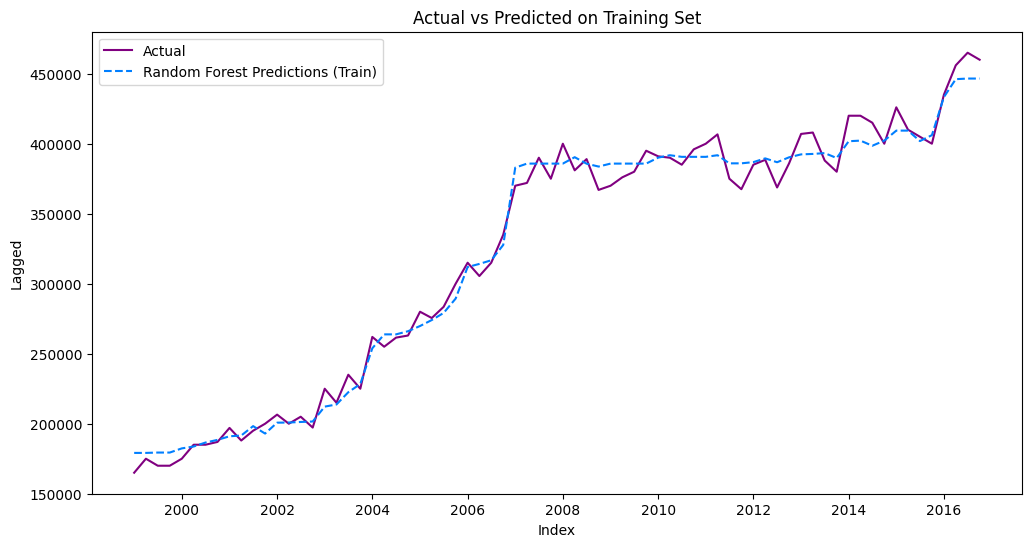

In [115]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, y_train.values, label='Actual', linestyle='-', color='purple')
plt.plot(train.index, train_pred, label='Random Forest Predictions (Train)', linestyle='--', color='#007FFF')
plt.xlabel('Index')
plt.ylabel('Lagged')
plt.title('Actual vs Predicted on Training Set')
plt.legend()
plt.show()

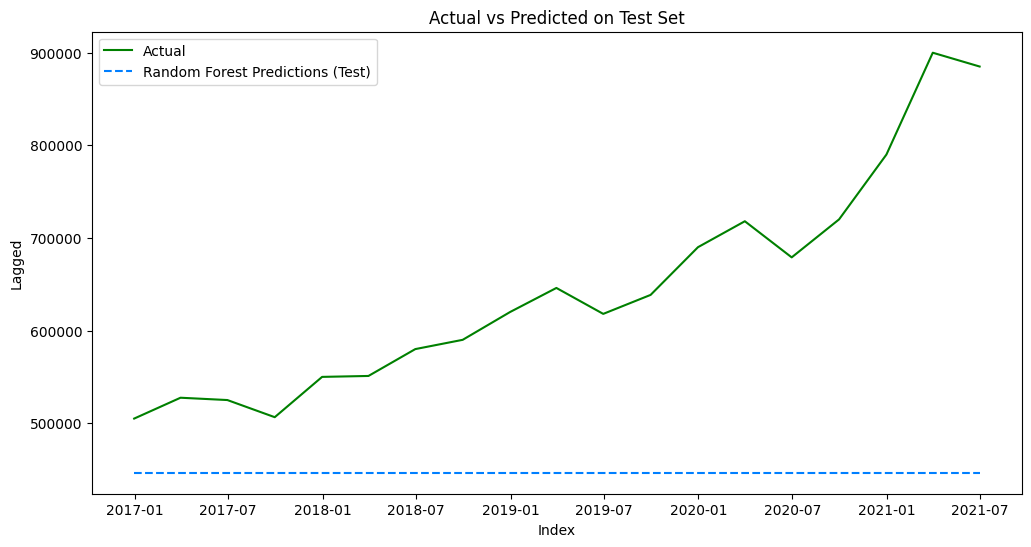

In [116]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test.values, label='Actual', linestyle='-', color='green')
plt.plot(test.index, test_pred, label='Random Forest Predictions (Test)', linestyle='--', color='#007FFF')
plt.xlabel('Index')
plt.ylabel('Lagged')
plt.title('Actual vs Predicted on Test Set')
plt.legend()
plt.show()

---